In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim

from sklearn import decomposition
from sklearn.datasets import fetch_openml

In [2]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")
fig_w, fig_h = plt.rcParams['figure.figsize']

#### Helper Functions

In [3]:
# @title Helper functions


def downloadMNIST():
  """
  Download MNIST dataset and transform it to torch.Tensor

  Args:
    None

  Returns:
    x_train : training images (torch.Tensor) (60000, 28, 28)
    x_test  : test images (torch.Tensor) (10000, 28, 28)
    y_train : training labels (torch.Tensor) (60000, )
    y_train : test labels (torch.Tensor) (10000, )
  """
  X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
  # Trunk the data
  n_train = 60000
  n_test = 10000

  train_idx = np.arange(0, n_train)
  test_idx = np.arange(n_train, n_train + n_test)

  x_train, y_train = X[train_idx], y[train_idx]
  x_test, y_test = X[test_idx], y[test_idx]

  # Transform np.ndarrays to torch.Tensor
  x_train = torch.from_numpy(np.reshape(x_train,
                                        (len(x_train),
                                         28, 28)).astype(np.float32))
  x_test = torch.from_numpy(np.reshape(x_test,
                                       (len(x_test),
                                        28, 28)).astype(np.float32))

  y_train = torch.from_numpy(y_train.astype(int))
  y_test = torch.from_numpy(y_test.astype(int))

  return (x_train, y_train, x_test, y_test)


def init_weights_kaiming_uniform(layer):
  """
  Initializes weights from linear PyTorch layer
  with kaiming uniform distribution.

  Args:
    layer (torch.Module)
        Pytorch layer

  Returns:
    Nothing.
  """
  # check for linear PyTorch layer
  if isinstance(layer, nn.Linear):
    # initialize weights with kaiming uniform distribution
    nn.init.kaiming_uniform_(layer.weight.data)


def init_weights_kaiming_normal(layer):
  """
  Initializes weights from linear PyTorch layer
  with kaiming normal distribution.

  Args:
    layer (torch.Module)
        Pytorch layer

  Returns:
    Nothing.
  """
  # check for linear PyTorch layer
  if isinstance(layer, nn.Linear):
    # initialize weights with kaiming normal distribution
    nn.init.kaiming_normal_(layer.weight.data)


def get_layer_weights(layer):
  """
  Retrieves learnable parameters from PyTorch layer.

  Args:
    layer (torch.Module)
        Pytorch layer

  Returns:
    list with learnable parameters
  """
  # initialize output list
  weights = []

  # check whether layer has learnable parameters
  if layer.parameters():
    # copy numpy array representation of each set of learnable parameters
    for item in layer.parameters():
      weights.append(item.detach().numpy().copy())

  return weights


def eval_mse(y_pred, y_true):
  """
  Evaluates Mean Square Error (MSE) between y_pred and y_true

  Args:
    y_pred (torch.Tensor)
        prediction samples

    v (numpy array of floats)
        ground truth samples

  Returns:
    MSE(y_pred, y_true)
  """

  with torch.no_grad():
      criterion = nn.MSELoss()
      loss = criterion(y_pred, y_true)

  return float(loss)


def eval_bce(y_pred, y_true):
  """
  Evaluates Binary Cross-Entropy (BCE) between y_pred and y_true

  Args:
    y_pred (torch.Tensor)
        prediction samples

    v (numpy array of floats)
        ground truth samples

  Returns:
    BCE(y_pred, y_true)
  """

  with torch.no_grad():
      criterion = nn.BCELoss()
      loss = criterion(y_pred, y_true)

  return float(loss)


def plot_weights_ab(encoder_w_a, encoder_w_b, decoder_w_a, decoder_w_b,
                    label_a='init', label_b='train',
                    bins_encoder=0.5, bins_decoder=1.5):
  """
  Plots row of histograms with encoder and decoder weights
  between two training checkpoints.

  Args:
    encoder_w_a (iterable)
        encoder weights at checkpoint a

    encoder_w_b (iterable)
        encoder weights at checkpoint b

    decoder_w_a (iterable)
        decoder weights at checkpoint a

    decoder_w_b (iterable)
        decoder weights at checkpoint b

    label_a (string)
        label for checkpoint a

    label_b (string)
        label for checkpoint b

    bins_encoder (float)
        norm of extreme values for encoder bins

    bins_decoder (float)
        norm of extreme values for decoder bins

  Returns:
    Nothing.
  """

  plt.figure(figsize=(fig_w * 1.2, fig_h * 1.2))

  # plot encoder weights
  bins = np.linspace(-bins_encoder, bins_encoder, num=32)

  plt.subplot(221)
  plt.title('Encoder weights to unit 0')
  plt.hist(encoder_w_a[0].flatten(), bins=bins, alpha=0.3, label=label_a)
  plt.hist(encoder_w_b[0].flatten(), bins=bins, alpha=0.3, label=label_b)
  plt.legend()

  plt.subplot(222)
  plt.title('Encoder weights to unit 1')
  plt.hist(encoder_w_a[1].flatten(), bins=bins, alpha=0.3, label=label_a)
  plt.hist(encoder_w_b[1].flatten(), bins=bins, alpha=0.3, label=label_b)
  plt.legend()

  # plot decoder weights
  bins = np.linspace(-bins_decoder, bins_decoder, num=32)

  plt.subplot(223)
  plt.title('Decoder weights from unit 0')
  plt.hist(decoder_w_a[:, 0].flatten(), bins=bins, alpha=0.3, label=label_a)
  plt.hist(decoder_w_b[:, 0].flatten(), bins=bins, alpha=0.3, label=label_b)
  plt.legend()

  plt.subplot(224)
  plt.title('Decoder weights from unit 1')
  plt.hist(decoder_w_a[:, 1].flatten(), bins=bins, alpha=0.3, label=label_a)
  plt.hist(decoder_w_b[:, 1].flatten(), bins=bins, alpha=0.3, label=label_b)
  plt.legend()

  plt.tight_layout()
  plt.show()


def plot_row(images, show_n=10, image_shape=None):
  """
  Plots rows of images from list of iterables (iterables: list, numpy array
  or torch.Tensor). Also accepts single iterable.
  Randomly selects images in each list element if item count > show_n.

  Args:
    images (iterable or list of iterables)
        single iterable with images, or list of iterables

    show_n (integer)
        maximum number of images per row

    image_shape (tuple or list)
        original shape of image if vectorized form

  Returns:
    Nothing.
  """

  if not isinstance(images, (list, tuple)):
    images = [images]

  for items_idx, items in enumerate(images):

    items = np.array(items)
    if items.ndim == 1:
      items = np.expand_dims(items, axis=0)

    if len(items) > show_n:
      selected = np.random.choice(len(items), show_n, replace=False)
      items = items[selected]

    if image_shape is not None:
      items = items.reshape([-1] + list(image_shape))

    plt.figure(figsize=(len(items) * 1.5, 2))
    for image_idx, image in enumerate(items):

      plt.subplot(1, len(items), image_idx + 1)
      plt.imshow(image, cmap='gray', vmin=image.min(), vmax=image.max())
      plt.axis('off')

      plt.tight_layout()


def xy_lim(x):
  """
  Return arguments for plt.xlim and plt.ylim calculated from minimum
  and maximum of x.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        data to be plotted

  Returns:
    Nothing.
  """

  x_min = np.min(x, axis=0)
  x_max = np.max(x, axis=0)

  x_min = x_min - np.abs(x_max - x_min) * 0.05 - np.finfo(float).eps
  x_max = x_max + np.abs(x_max - x_min) * 0.05 + np.finfo(float).eps

  return [x_min[0], x_max[0]], [x_min[1], x_max[1]]


def plot_generative(x, decoder_fn, image_shape, n_row=16):
  """
  Plots images reconstructed by decoder_fn from a 2D grid in
  latent space that is determined by minimum and maximum values in x.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space

    decoder_fn (integer)
        function returning vectorized images from 2D latent space coordinates

    image_shape (tuple or list)
        original shape of image

    n_row
        number of rows in grid

  Returns:
    Nothing.
  """

  xlim, ylim = xy_lim(np.array(x))

  dx = (xlim[1] - xlim[0]) / n_row
  grid = [np.linspace(ylim[0] + dx / 2, ylim[1] - dx / 2, n_row),
          np.linspace(xlim[0] + dx / 2, xlim[1] - dx / 2, n_row)]

  canvas = np.zeros((image_shape[0]*n_row, image_shape[1] * n_row))

  cmap = plt.get_cmap('gray')

  for j, latent_y in enumerate(grid[0][::-1]):
    for i, latent_x in enumerate(grid[1]):

      latent = np.array([[latent_x, latent_y]], dtype=np.float32)
      with torch.no_grad():
          x_decoded = decoder_fn(torch.from_numpy(latent))

      x_decoded = x_decoded.reshape(image_shape)

      canvas[j*image_shape[0]: (j + 1) * image_shape[0],
             i*image_shape[1]: (i + 1) * image_shape[1]] = x_decoded

  plt.imshow(canvas, cmap=cmap, vmin=canvas.min(), vmax=canvas.max())
  plt.axis('off')


def plot_latent(x, y, show_n=500, fontdict=None, xy_labels=None):
  """
  Plots digit class of each sample in 2D latent space coordinates.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    n_row (integer)
        number of samples

    fontdict (dictionary)
        optional style option for plt.text

    xy_labels (list)
        optional list with [xlabel, ylabel]

  Returns:
    Nothing.
  """

  if fontdict is None:
    fontdict = {'weight': 'bold', 'size': 12}

  cmap = plt.get_cmap('tab10')

  if len(x) > show_n:
    selected = np.random.choice(len(x), show_n, replace=False)
    x = x[selected]
    y = y[selected]

  for my_x, my_y in zip(x, y):
    plt.text(my_x[0], my_x[1], str(int(my_y)),
             color=cmap(int(my_y) / 10.),
             fontdict=fontdict,
             horizontalalignment='center',
             verticalalignment='center',
             alpha=0.8)

  if xy_labels is None:
    xy_labels = ['$Z_1$', '$Z_2$']

  plt.xlabel(xy_labels[0])
  plt.ylabel(xy_labels[1])

  xlim, ylim = xy_lim(np.array(x))
  plt.xlim(xlim)
  plt.ylim(ylim)


def plot_latent_generative(x, y, decoder_fn, image_shape, title=None,
                           xy_labels=None):
  """
  Two horizontal subplots generated with encoder map and decoder grid.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    decoder_fn (integer)
        function returning vectorized images from 2D latent space coordinates

    image_shape (tuple or list)
        original shape of image

    title (string)
        plot title

    xy_labels (list)
        optional list with [xlabel, ylabel]

  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=(12, 6))

  if title is not None:
    fig.suptitle(title, y=1.05)

  ax = fig.add_subplot(121)
  ax.set_title('Encoder map', y=1.05)
  plot_latent(x, y, xy_labels=xy_labels)

  ax = fig.add_subplot(122)
  ax.set_title('Decoder grid', y=1.05)
  plot_generative(x, decoder_fn, image_shape)

  plt.tight_layout()
  plt.show()


def plot_latent_ab(x1, x2, y, selected_idx=None,
                   title_a='Before', title_b='After', show_n=500):
  """
  Two horizontal subplots with encoder maps.

  Args:
    x1 (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space (left plot)

    x2 (list, numpy array or torch.Tensor of floats)
        digit class of each sample (right plot)

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    selected_idx (list of integers)
        indexes of elements to be plotted

    show_n (integer)
        maximum number of samples in each plot

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)

  Returns:
    Nothing.
  """

  fontdict = {'weight': 'bold', 'size': 12}

  if len(x1) > show_n:

    if selected_idx is None:
      selected_idx = np.random.choice(len(x1), show_n, replace=False)

    x1 = x1[selected_idx]
    x2 = x2[selected_idx]
    y = y[selected_idx]

  plt.figure(figsize=(12, 6))

  ax = plt.subplot(121)
  ax.set_title(title_a, y=1.05)
  plot_latent(x1, y, fontdict=fontdict)

  ax = plt.subplot(122)
  ax.set_title(title_b, y=1.05)
  plot_latent(x2, y, fontdict=fontdict)

  plt.tight_layout()


def runSGD(net, input_train, input_test, criterion='bce',
           n_epochs=10, batch_size=32, verbose=False):
  """
  Trains autoencoder network with stochastic gradient descent with Adam
  optimizer and loss criterion. Train samples are shuffled, and loss is
  displayed at the end of each opoch for both MSE and BCE. Plots training loss
  at each minibatch (maximum of 500 randomly selected values).

  Args:
    net (torch network)
        ANN object (nn.Module)

    input_train (torch.Tensor)
        vectorized input images from train set

    input_test (torch.Tensor)
        vectorized input images from test set

    criterion (string)
        train loss: 'bce' or 'mse'

    n_epochs (boolean)
        number of full iterations of training data

    batch_size (integer)
        number of element in mini-batches

    verbose (boolean)
        whether to print final loss

  Returns:
    Nothing.
  """

  # Initialize loss function
  if criterion == 'mse':
    loss_fn = nn.MSELoss()
  elif criterion == 'bce':
    loss_fn = nn.BCELoss()
  else:
    print('Please specify either "mse" or "bce" for loss criterion')

  # Initialize SGD optimizer
  optimizer = optim.Adam(net.parameters())

  # Placeholder for loss
  track_loss = []

  print('Epoch', '\t', 'Loss train', '\t', 'Loss test')
  for i in range(n_epochs):

    shuffle_idx = np.random.permutation(len(input_train))
    batches = torch.split(input_train[shuffle_idx], batch_size)

    for batch in batches:

      output_train = net(batch)
      loss = loss_fn(output_train, batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Keep track of loss at each epoch
      track_loss += [float(loss)]

    loss_epoch = f'{i + 1} / {n_epochs}'
    with torch.no_grad():
      output_train = net(input_train)
      loss_train = loss_fn(output_train, input_train)
      loss_epoch += f'\t {loss_train:.4f}'

      output_test = net(input_test)
      loss_test = loss_fn(output_test, input_test)
      loss_epoch += f'\t\t {loss_test:.4f}'

    print(loss_epoch)

  if verbose:
    # Print final loss
    loss_mse = f'\nMSE\t {eval_mse(output_train, input_train):0.4f}'
    loss_mse += f'\t\t {eval_mse(output_test, input_test):0.4f}'
    print(loss_mse)

    loss_bce = f'BCE\t {eval_bce(output_train, input_train):0.4f}'
    loss_bce += f'\t\t {eval_bce(output_test, input_test):0.4f}'
    print(loss_bce)

  # Plot loss
  step = int(np.ceil(len(track_loss) / 500))
  x_range = np.arange(0, len(track_loss), step)
  plt.figure()
  plt.plot(x_range, track_loss[::step], 'C0')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.xlim([0, None])
  plt.ylim([0, None])
  plt.show()

#### Auto--encoders

In [4]:
# Download MNIST
x_train, y_train, x_test, y_test = downloadMNIST()

x_train = x_train / 255
x_test = x_test / 255

image_shape = x_train.shape[1:]

input_size = np.prod(image_shape)

input_train = x_train.reshape([-1, input_size])
input_test = x_test.reshape([-1, input_size])

test_selected_idx = np.random.choice(len(x_test), 10, replace=False)
train_selected_idx = np.random.choice(len(x_train), 10, replace=False)

print(f'shape x_train \t\t {x_train.shape}')
print(f'shape x_test \t\t {x_test.shape}')
print(f'shape image \t\t {image_shape}')
print(f'shape input_train \t {input_train.shape}')
print(f'shape input_test \t {input_test.shape}')

shape x_train 		 torch.Size([60000, 28, 28])
shape x_test 		 torch.Size([10000, 28, 28])
shape image 		 torch.Size([28, 28])
shape input_train 	 torch.Size([60000, 784])
shape input_test 	 torch.Size([10000, 784])


In [5]:
svd = decomposition.TruncatedSVD(n_components=2)

svd.fit(input_train)

svd_latent_train = svd.transform(input_train)
svd_latent_test = svd.transform(input_test)

svd_reconstruction_train = svd.inverse_transform(svd_latent_train)
svd_reconstruction_test = svd.inverse_transform(svd_latent_test)

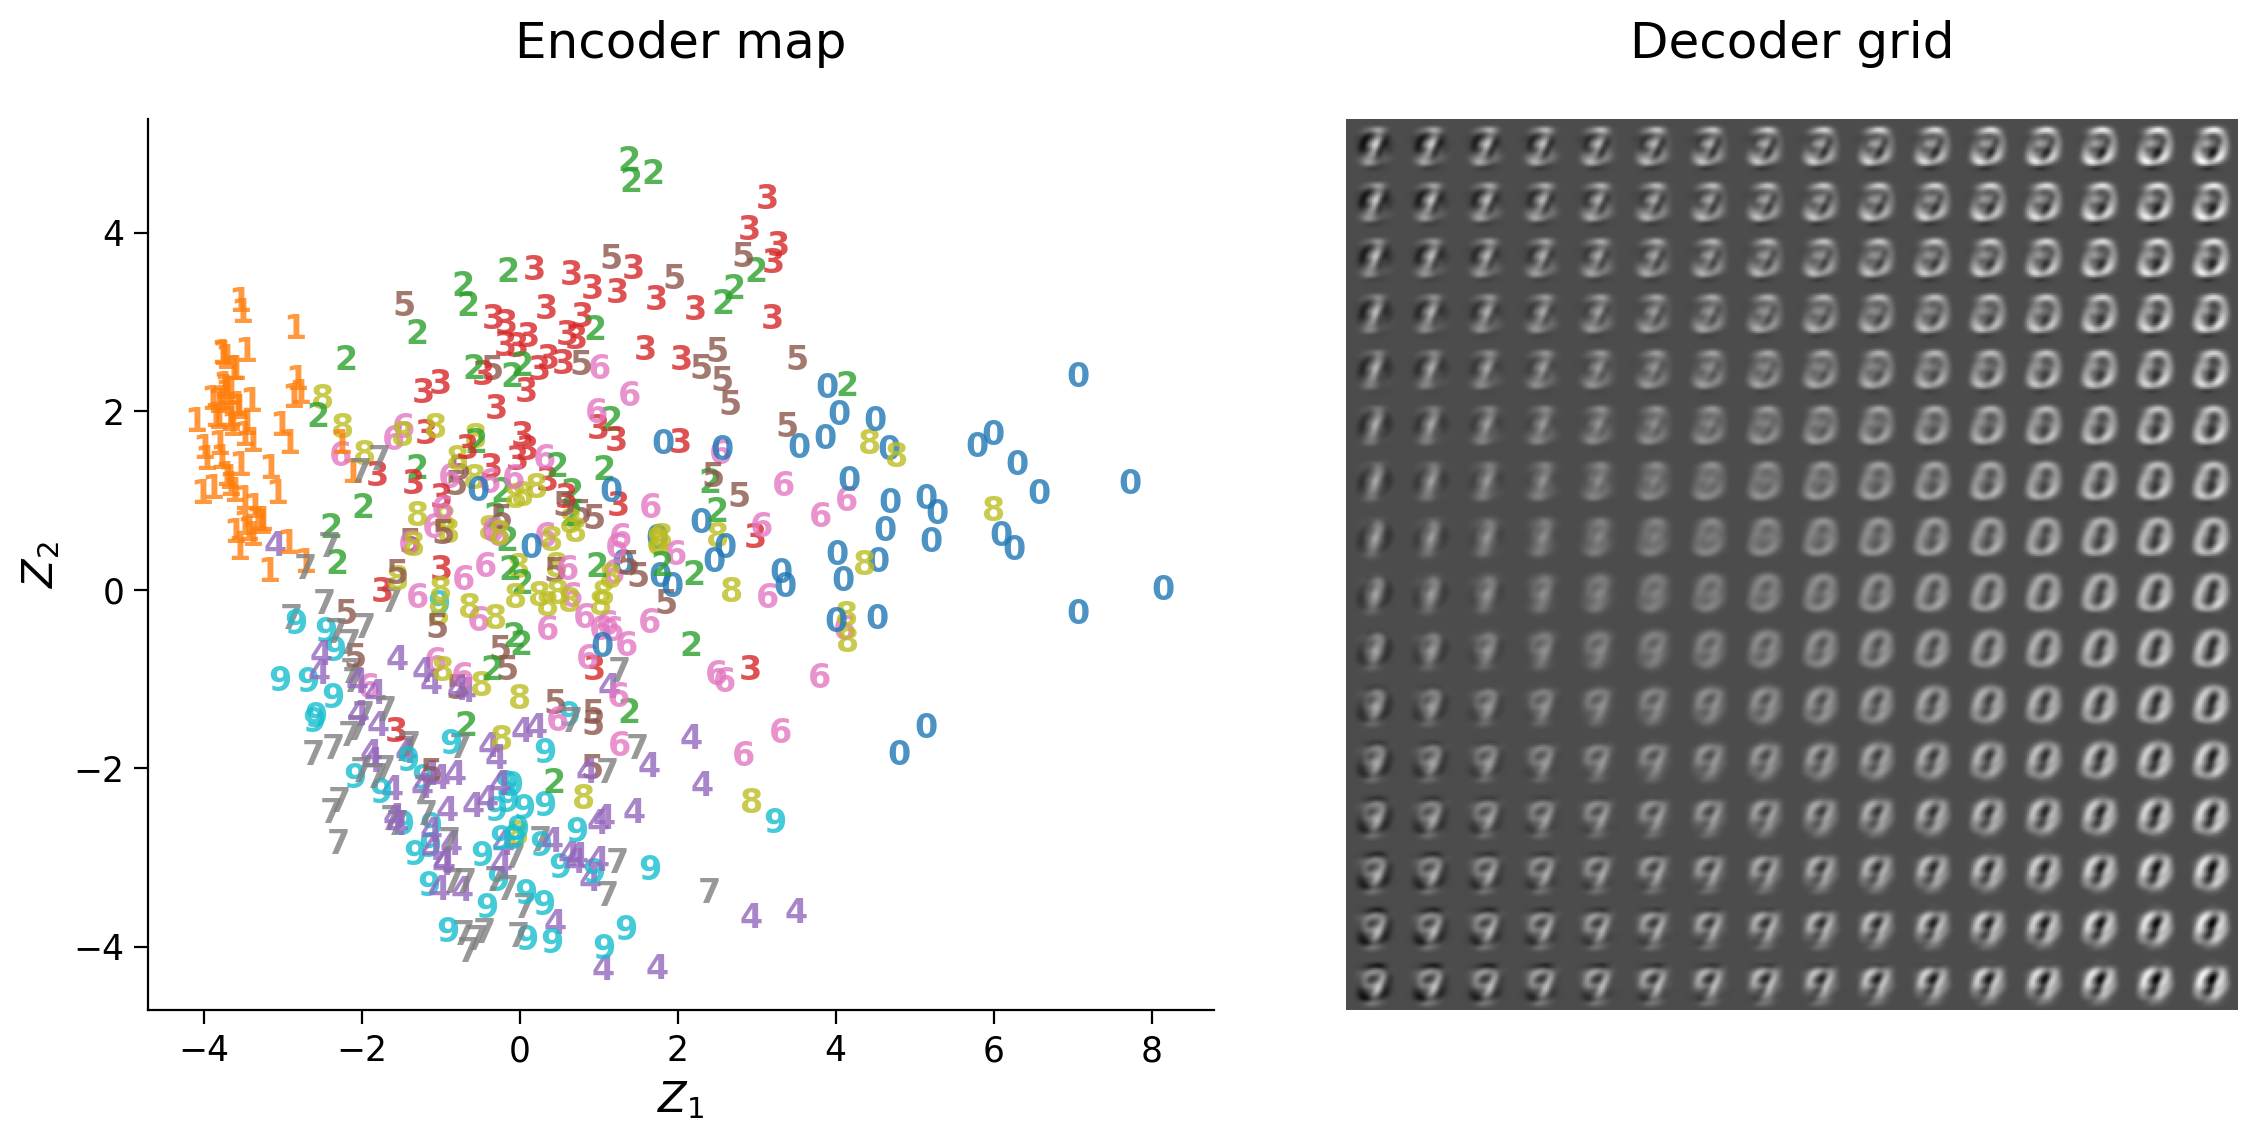

In [6]:
## perform PCA and visualize latent space and reconstruction

# create the model
pca = decomposition.PCA(n_components=2)
# fit the model on training data
pca.fit(input_train)
# transformation on 2D space
pca_latent_test = pca.transform(input_test)

plot_latent_generative(pca_latent_test, y_test, pca.inverse_transform,
                       image_shape=image_shape)

/tmp/ipykernel_79569/3600056542.py:242: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  items = np.array(items)


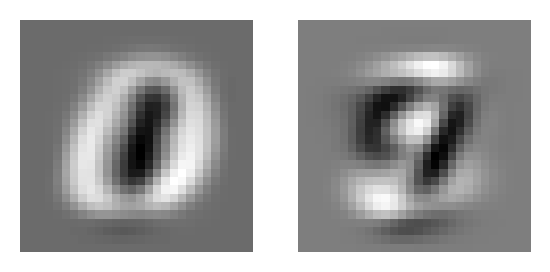

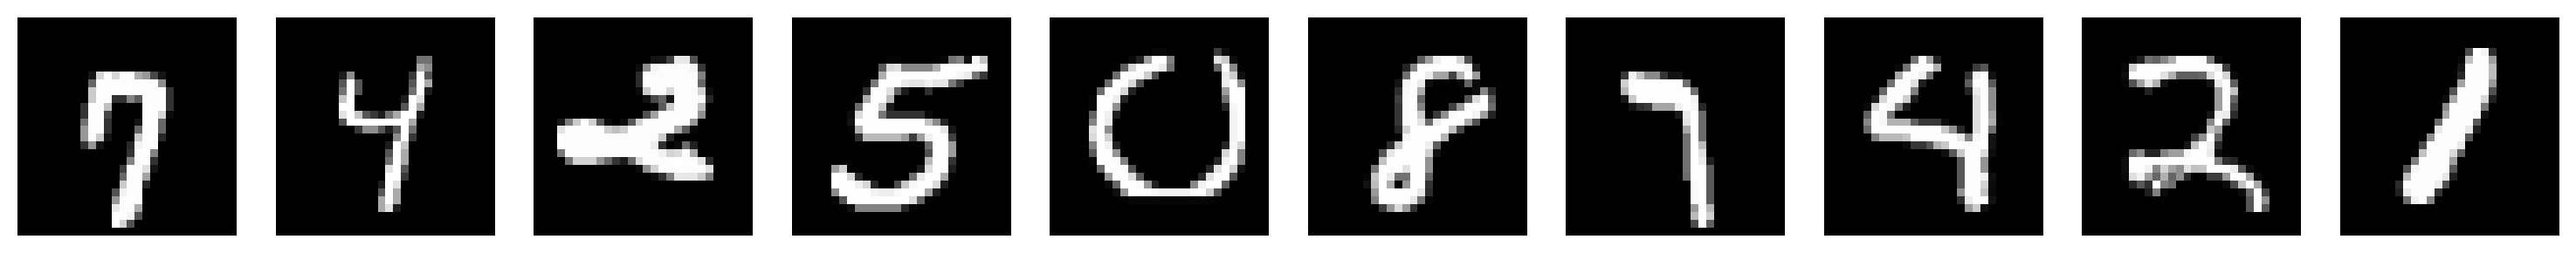

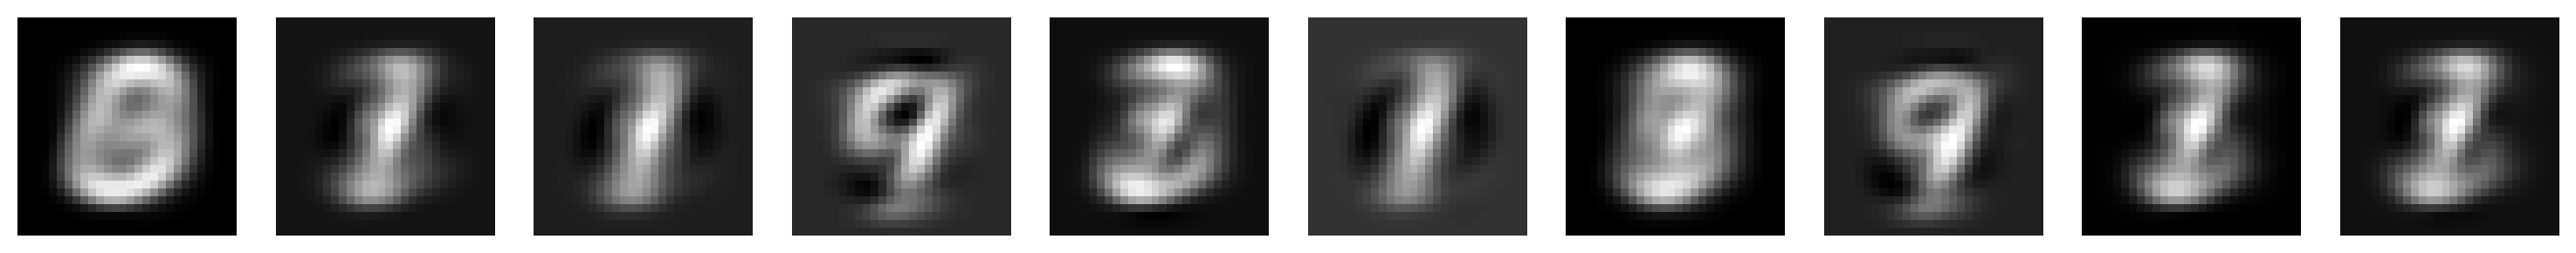

In [7]:
pca_components = pca.components_

plot_row(pca_components, image_shape=image_shape)
pca_output_test = pca.inverse_transform(pca_latent_test)

plot_row([input_test, pca_output_test], image_shape=image_shape)

In [8]:
encoding_size = 32


## add linear and sigmoid layers

model = nn.Sequential(
    nn.Linear(input_size, encoding_size),
    nn.ReLU(),
    nn.Linear(encoding_size, input_size),
    nn.Sigmoid()
    )

print(f'Model structure \n\n {model}')

Model structure 

 Sequential(
  (0): Linear(in_features=784, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=784, bias=True)
  (3): Sigmoid()
)


/tmp/ipykernel_79569/3600056542.py:242: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  items = np.array(items)


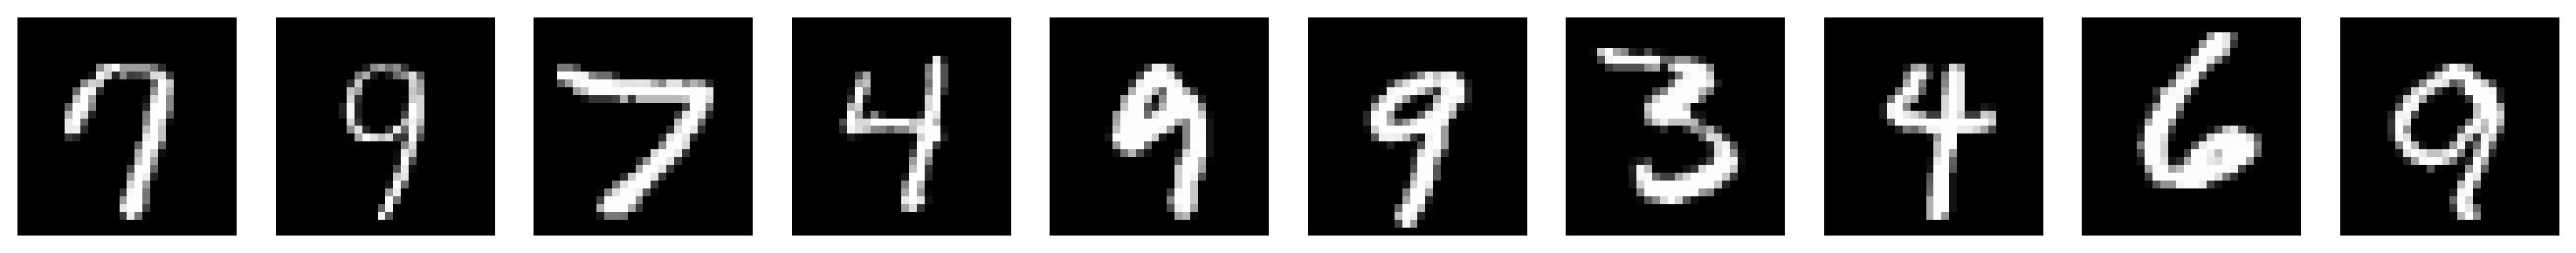

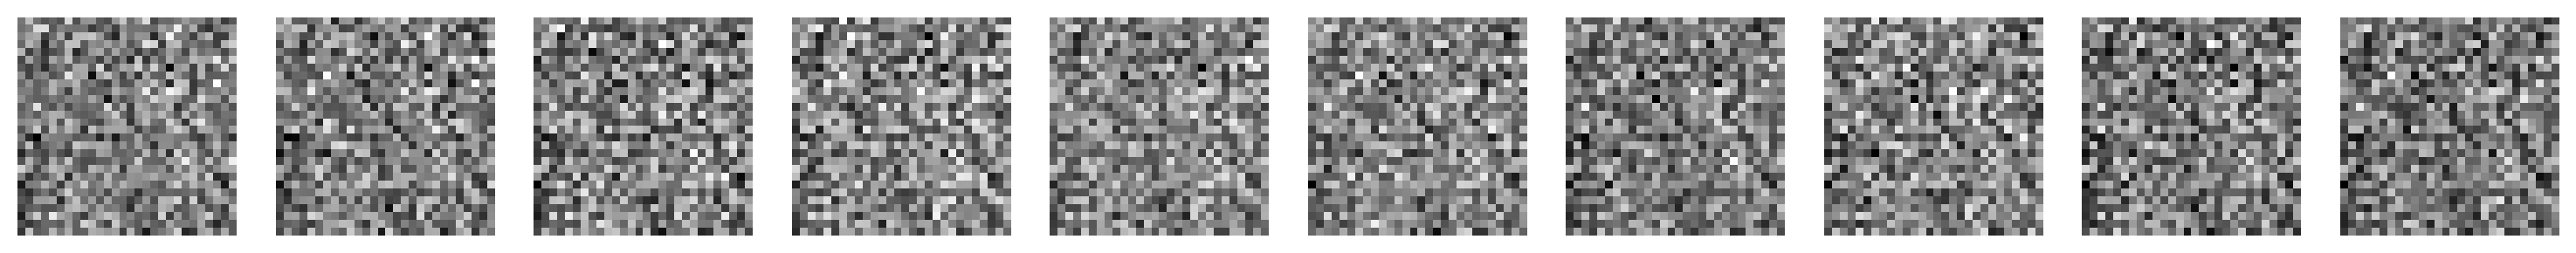

In [9]:
with torch.no_grad():
  output_test = model(input_test)

plot_row([input_test.float(), output_test], image_shape=image_shape)

Epoch 	 Loss train 	 Loss test


/tmp/ipykernel_79569/3600056542.py:546: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  track_loss += [float(loss)]


1 / 10	 0.0260		 0.0256
2 / 10	 0.0188		 0.0185
3 / 10	 0.0162		 0.0158
4 / 10	 0.0153		 0.0149
5 / 10	 0.0149		 0.0145
6 / 10	 0.0147		 0.0144
7 / 10	 0.0145		 0.0141
8 / 10	 0.0145		 0.0141
9 / 10	 0.0144		 0.0140
10 / 10	 0.0143		 0.0140


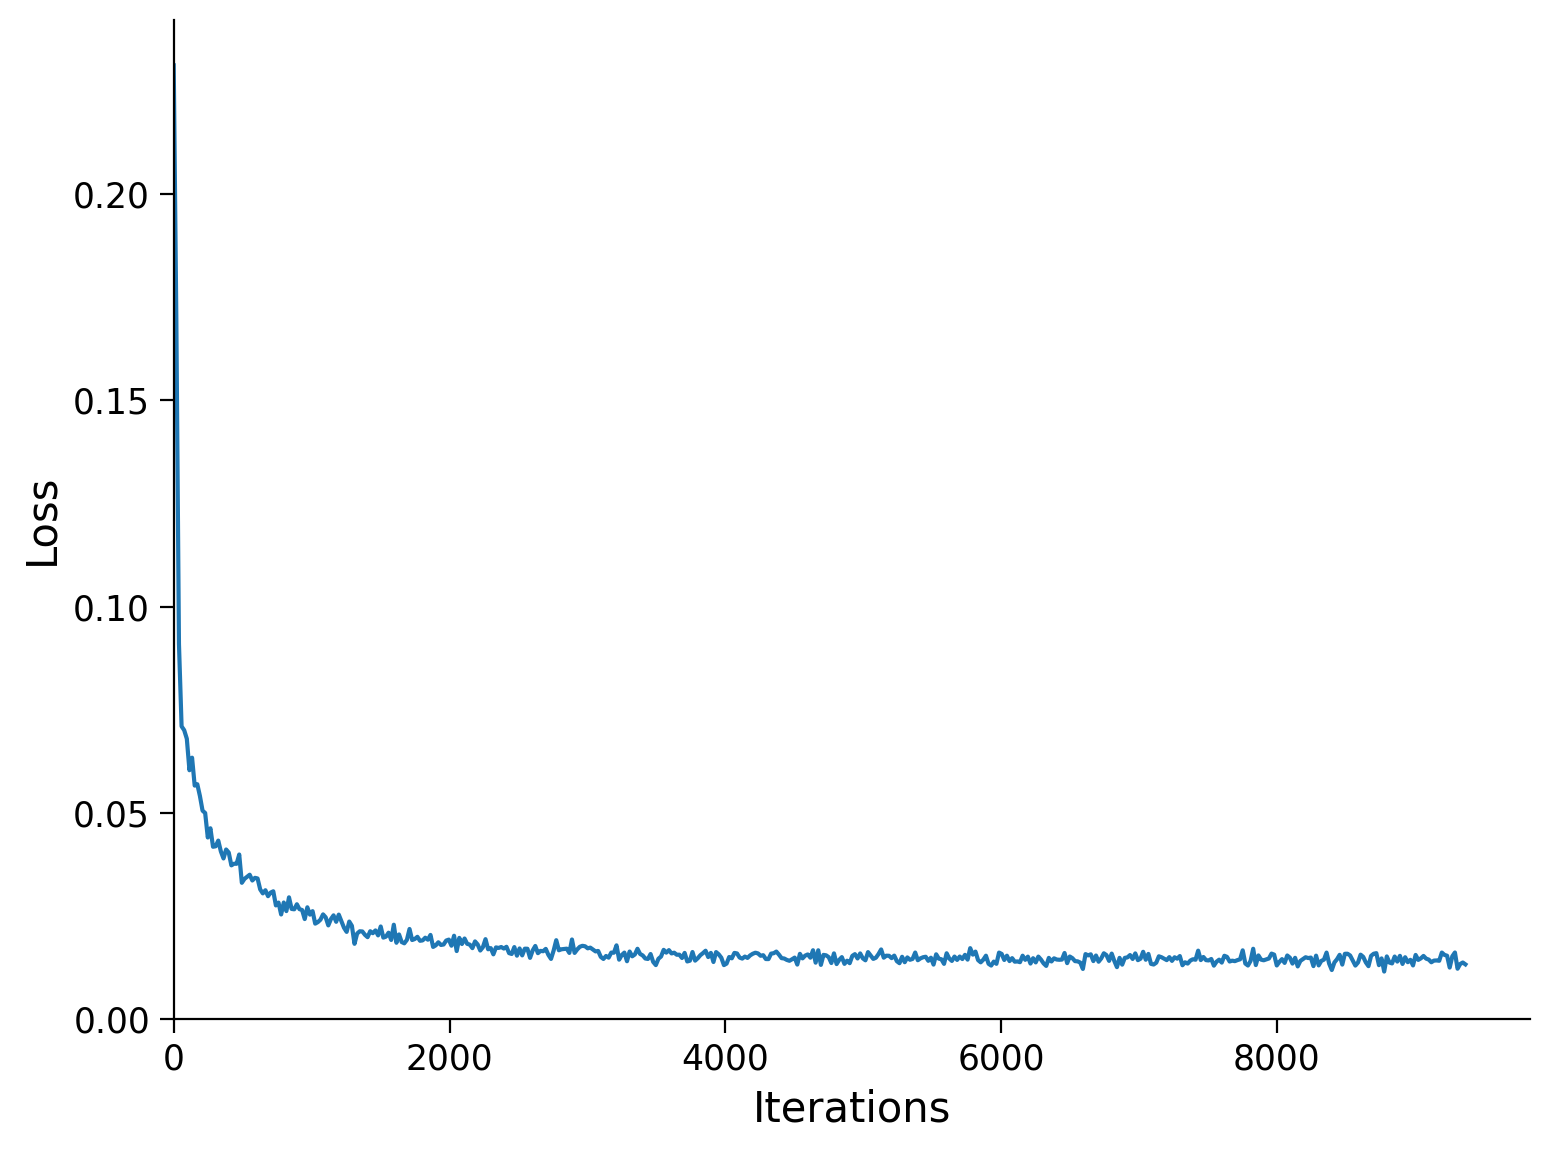

In [10]:
n_epochs = 10
batch_size = 64

runSGD(model, input_train, input_test, criterion='mse',
       n_epochs=n_epochs, batch_size=batch_size)

/tmp/ipykernel_79569/3600056542.py:242: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  items = np.array(items)


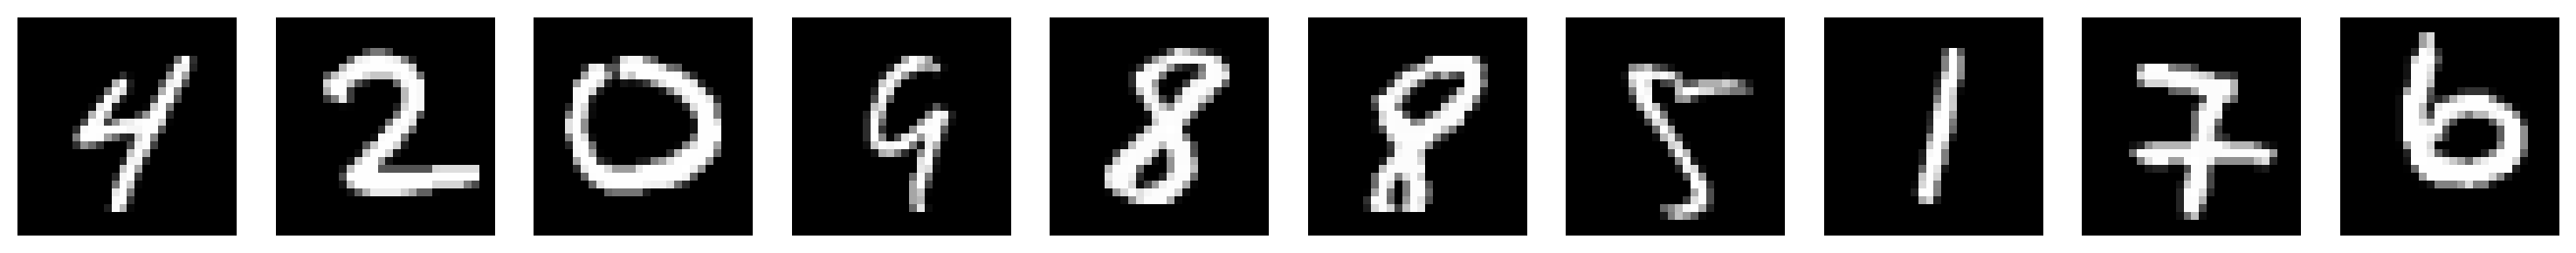

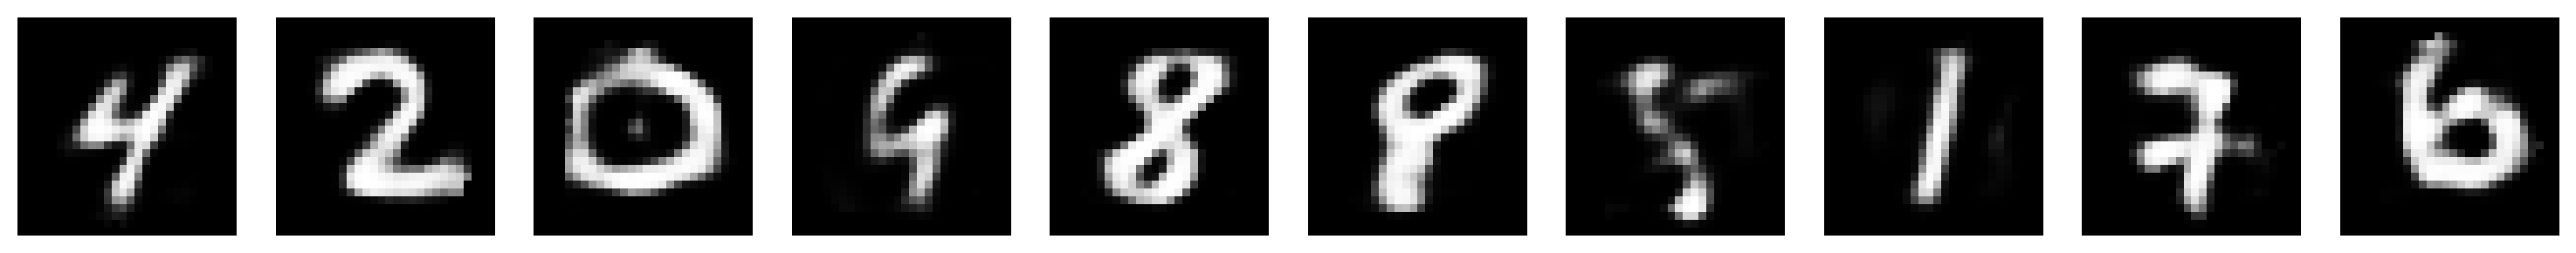

In [11]:
with torch.no_grad():
  output_test = model(input_test)

plot_row([input_test[test_selected_idx], output_test[test_selected_idx]],
         image_shape=image_shape)

Epoch 	 Loss train 	 Loss test
1 / 2	 0.0262		 0.0258
2 / 2	 0.0183		 0.0180

MSE	 0.0183		 0.0180
BCE	 0.1335		 0.1317


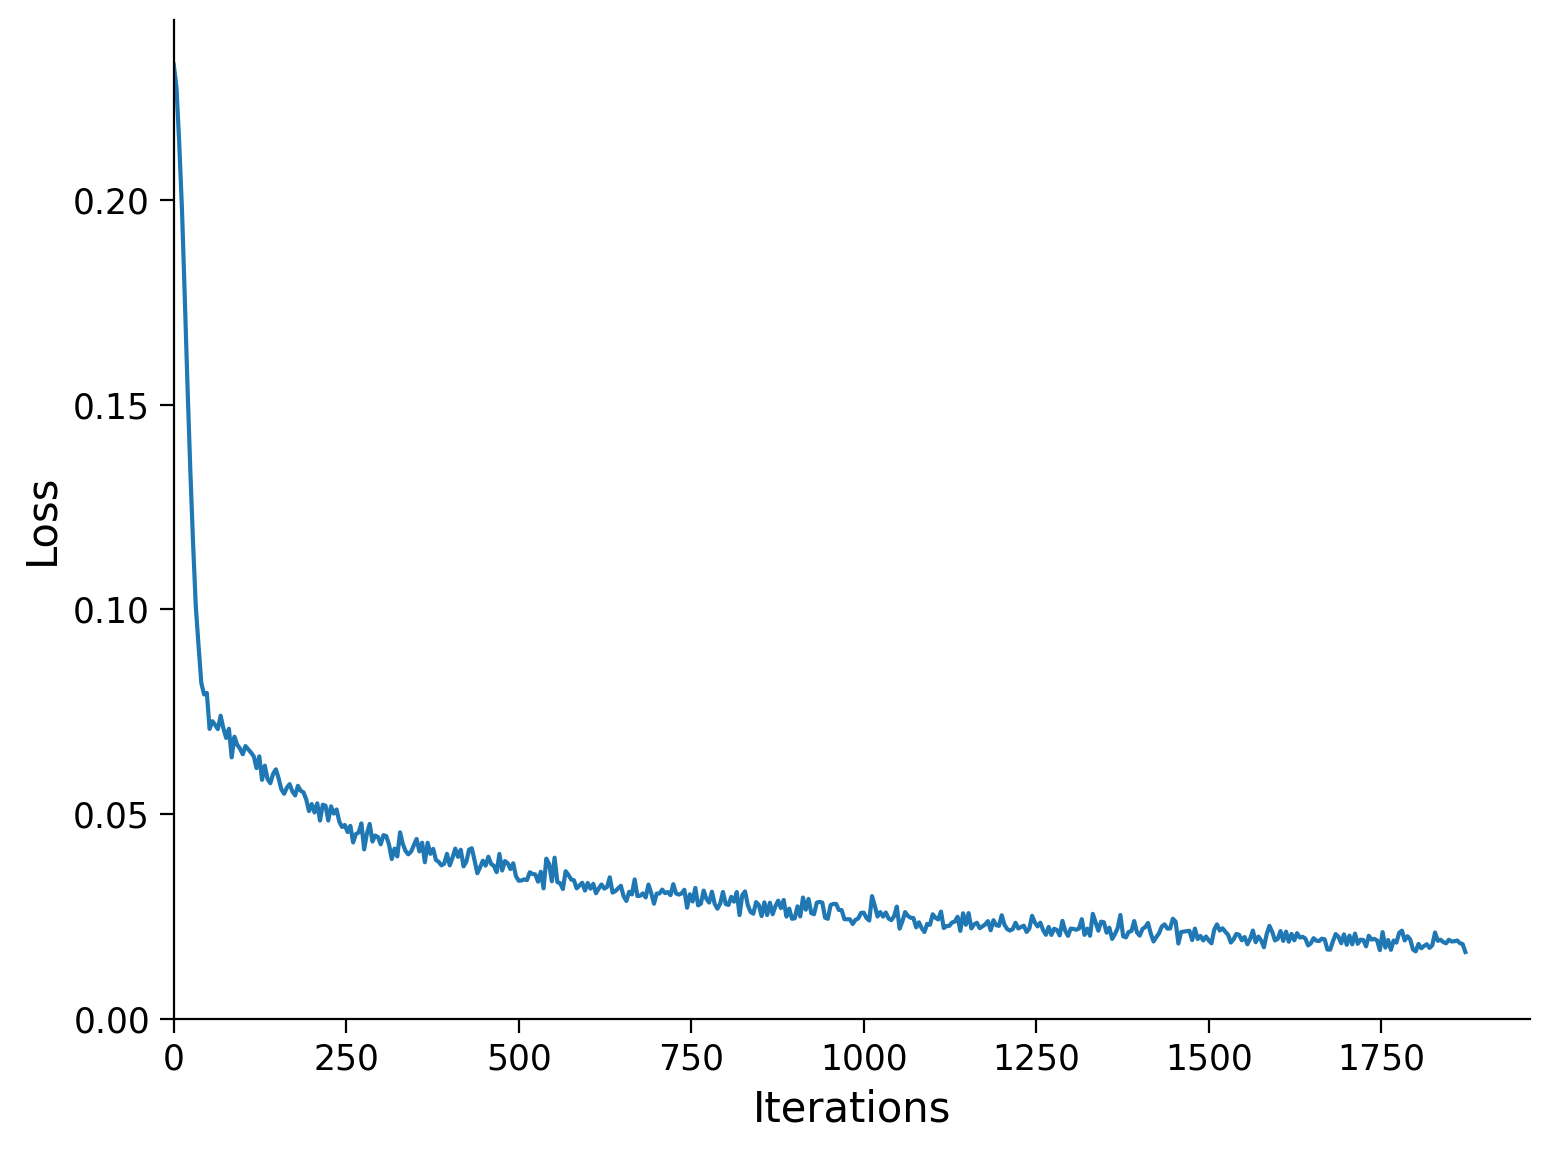

/tmp/ipykernel_79569/3600056542.py:242: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  items = np.array(items)


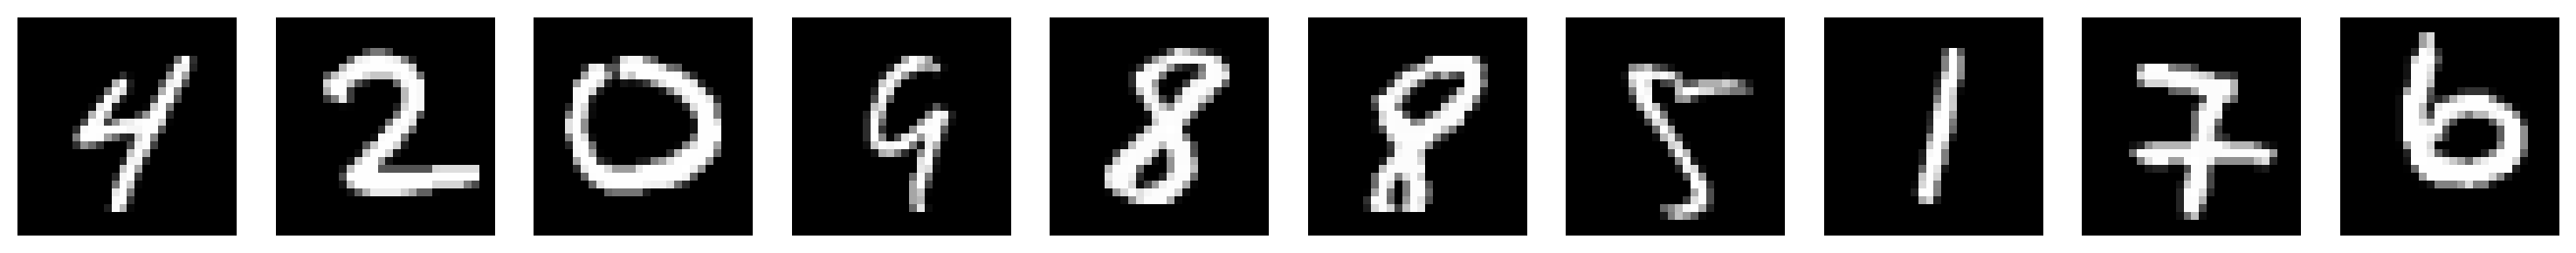

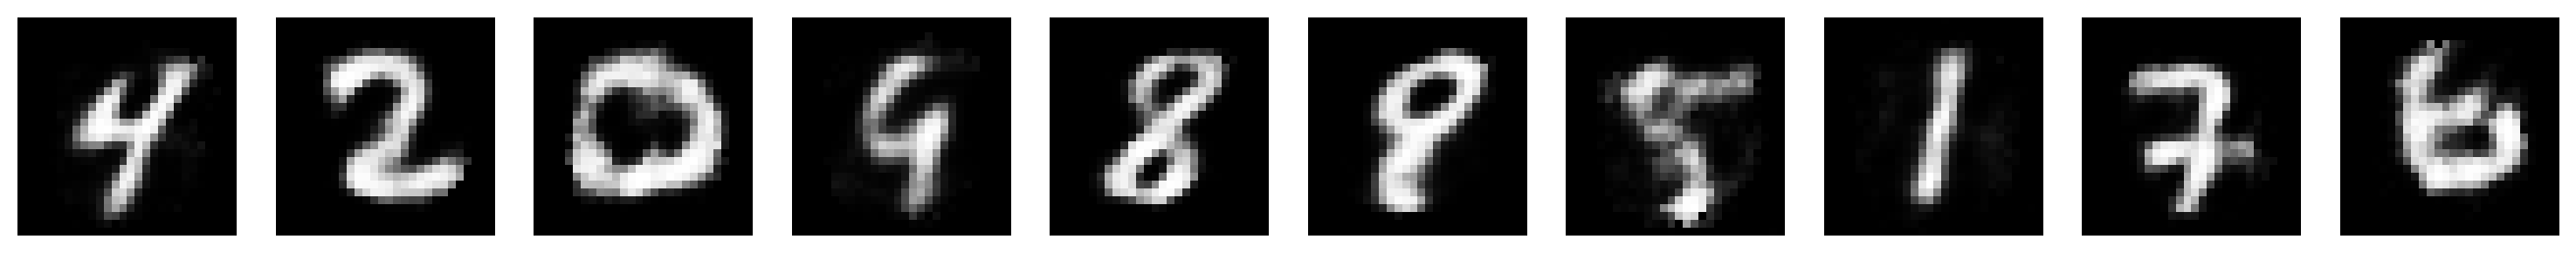

In [12]:
# MSE loss function

encoding_size = 32
n_epochs = 2
batch_size = 64

model = nn.Sequential(
    nn.Linear(input_size, encoding_size),
    nn.ReLU(),
    nn.Linear(encoding_size, input_size),
    nn.Sigmoid()
    )

runSGD(model, input_train, input_test, criterion='mse',
       n_epochs=n_epochs, batch_size=batch_size, verbose=True)


with torch.no_grad():
  output_test = model(input_test)

plot_row([input_test[test_selected_idx], output_test[test_selected_idx]],
         image_shape=image_shape)

Epoch 	 Loss train 	 Loss test
1 / 2	 0.1487		 0.1472
2 / 2	 0.1248		 0.1234

MSE	 0.0199		 0.0195
BCE	 0.1248		 0.1234


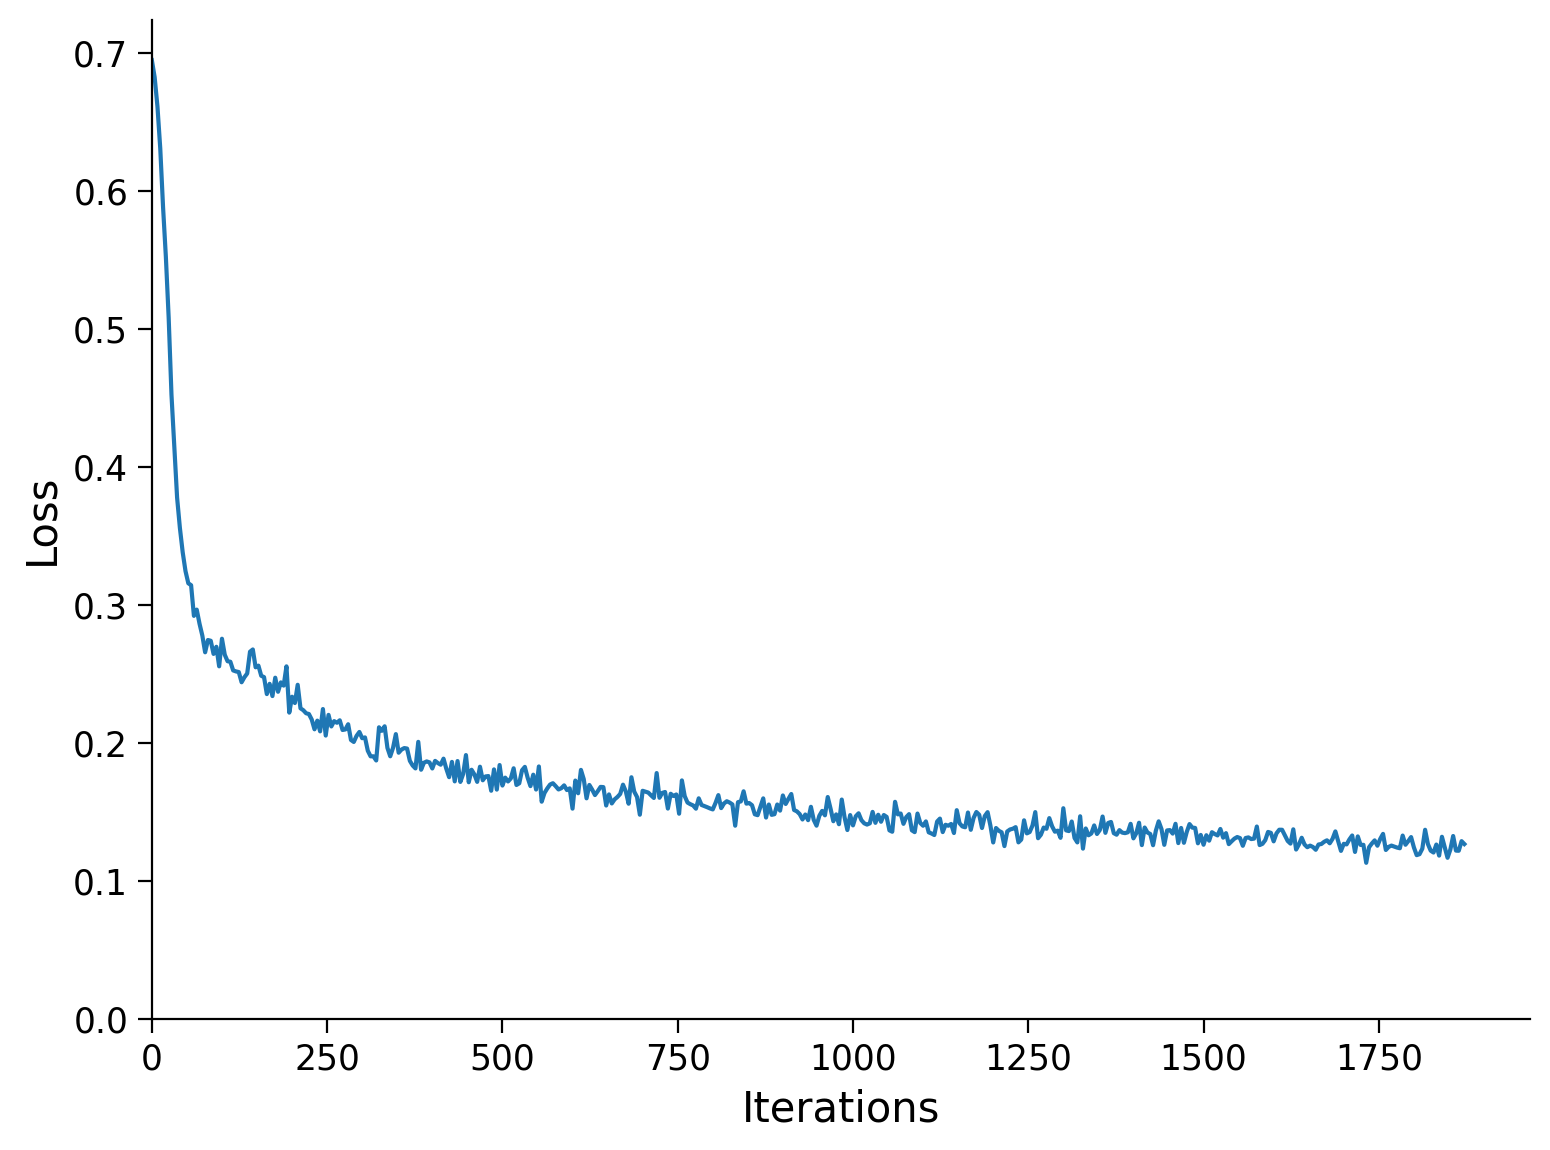

/tmp/ipykernel_79569/3600056542.py:242: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  items = np.array(items)


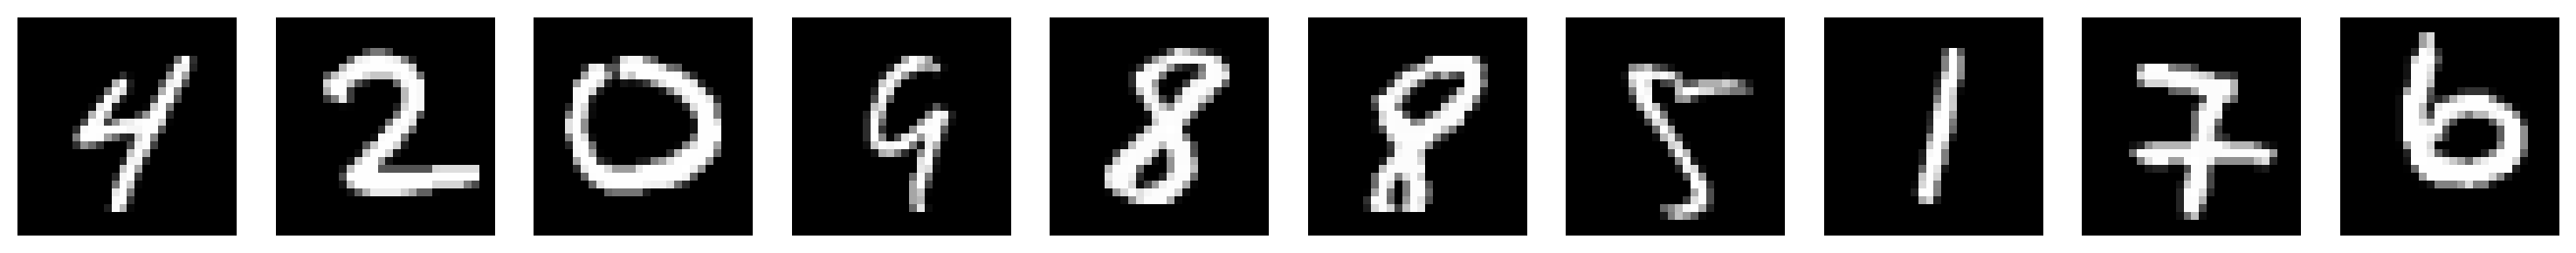

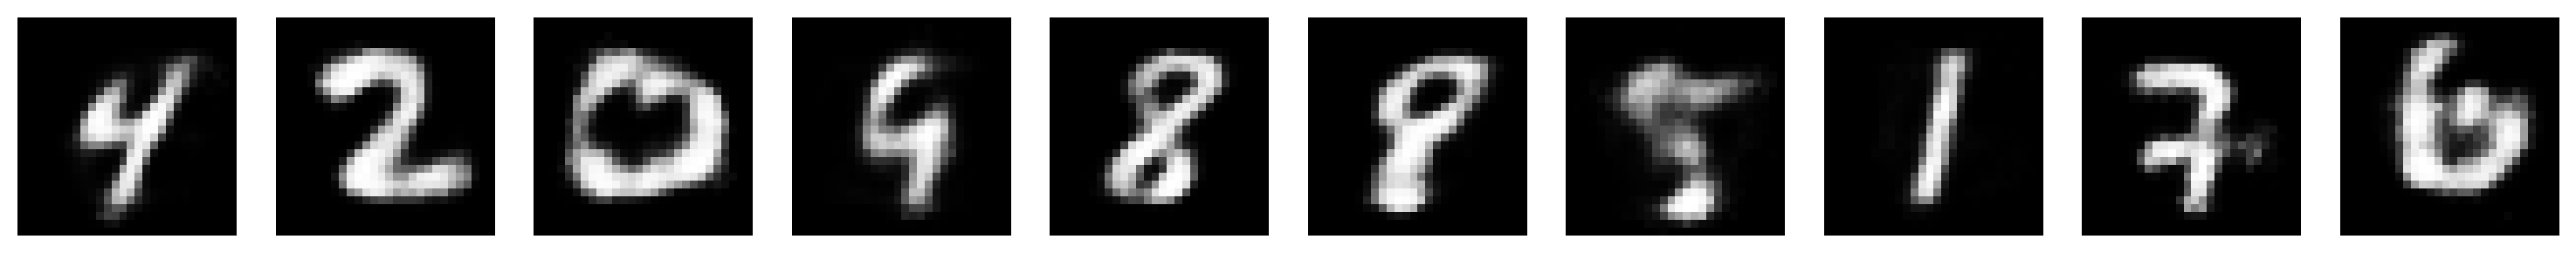

In [13]:
### BCE loss function

encoding_size = 32
n_epochs = 2
batch_size = 64

model = nn.Sequential(
    nn.Linear(input_size, encoding_size),
    nn.ReLU(),
    nn.Linear(encoding_size, input_size),
    nn.Sigmoid()
    )

runSGD(model, input_train, input_test, criterion='bce',
       n_epochs=n_epochs, batch_size=batch_size, verbose=True)

with torch.no_grad():
  output_test = model(input_test)

plot_row([input_test[test_selected_idx], output_test[test_selected_idx]],
         image_shape=image_shape)

#### Encoder - Decoder

In [14]:
encoding_size = 2

model = nn.Sequential(
    nn.Linear(input_size, encoding_size),
    nn.PReLU(),
    nn.Linear(encoding_size, input_size),
    nn.Sigmoid()
    )

encoder = model[:2]
decoder = model[2:]

print(f'Autoencoder \n\n {model}')
print(f'Encoder \n\n {encoder}')
print(f'Encoder \n\n {decoder}')

Autoencoder 

 Sequential(
  (0): Linear(in_features=784, out_features=2, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=2, out_features=784, bias=True)
  (3): Sigmoid()
)
Encoder 

 Sequential(
  (0): Linear(in_features=784, out_features=2, bias=True)
  (1): PReLU(num_parameters=1)
)
Encoder 

 Sequential(
  (2): Linear(in_features=2, out_features=784, bias=True)
  (3): Sigmoid()
)


Epoch 	 Loss train 	 Loss test
1 / 10	 0.2634		 0.2631
2 / 10	 0.2577		 0.2574
3 / 10	 0.2530		 0.2528
4 / 10	 0.2472		 0.2470
5 / 10	 0.2415		 0.2412
6 / 10	 0.2374		 0.2369
7 / 10	 0.2351		 0.2346
8 / 10	 0.2337		 0.2331
9 / 10	 0.2325		 0.2319
10 / 10	 0.2312		 0.2306


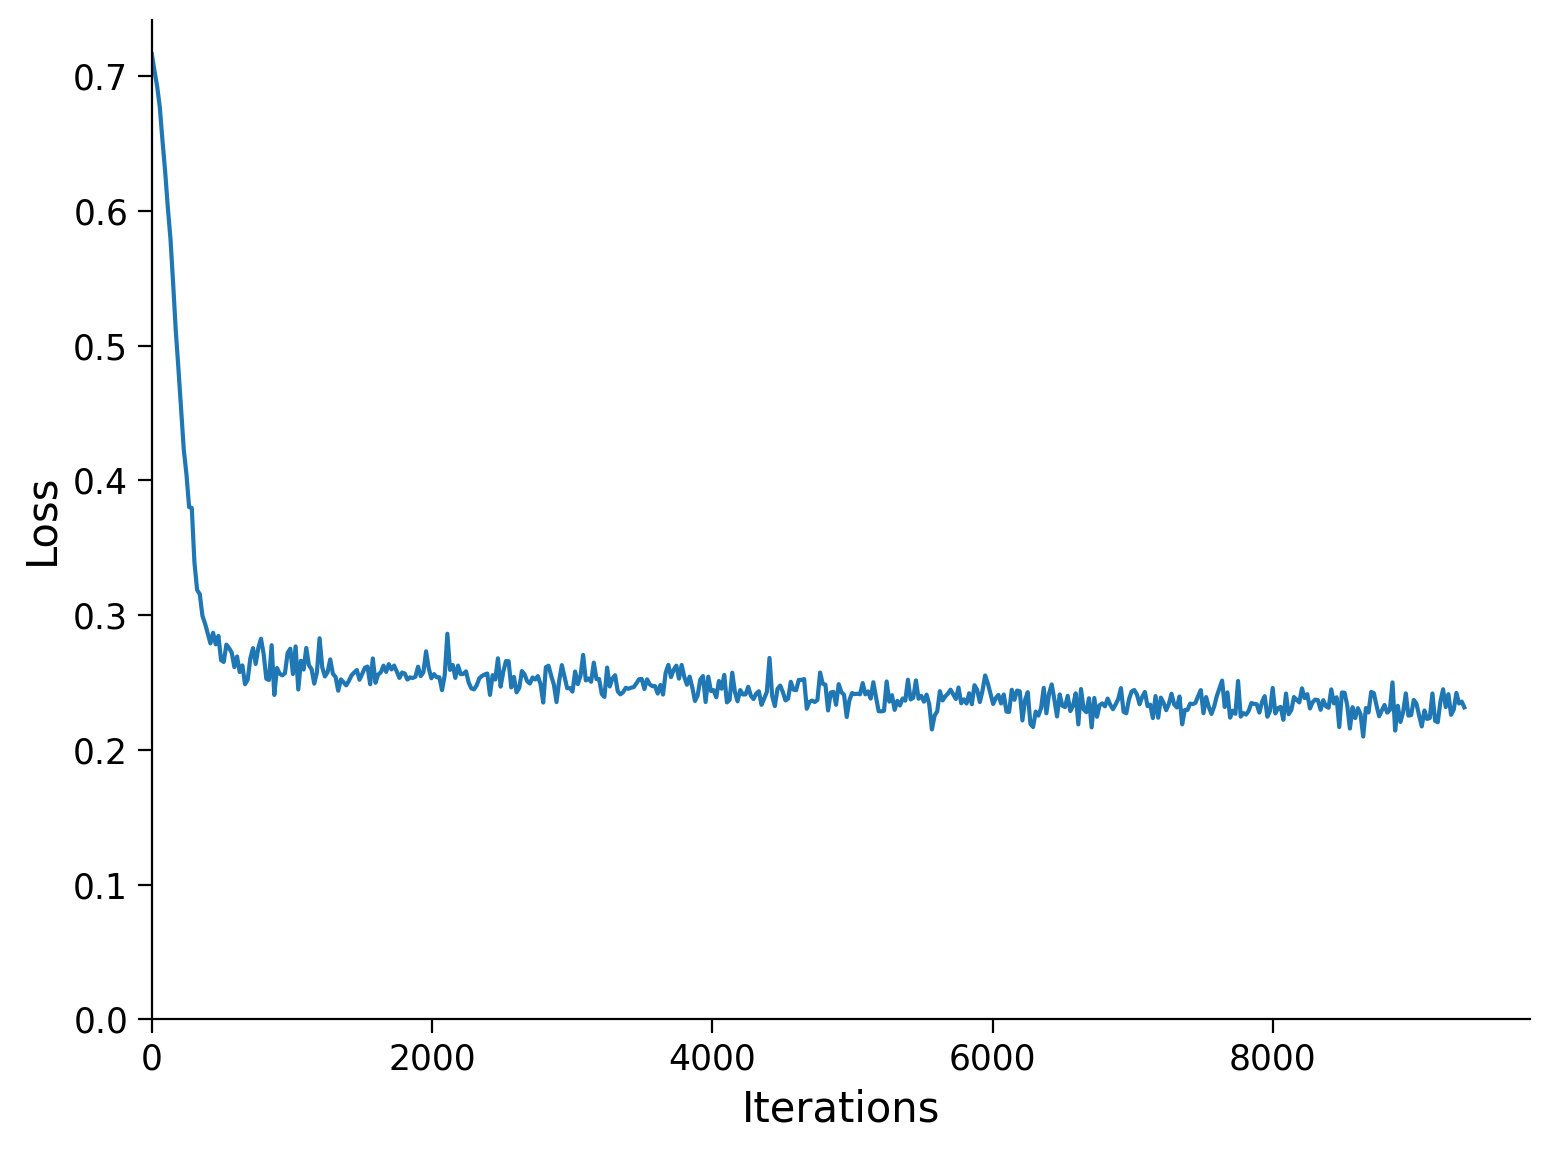

/tmp/ipykernel_79569/3600056542.py:381: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xlim, ylim = xy_lim(np.array(x))
/tmp/ipykernel_79569/3600056542.py:307: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xlim, ylim = xy_lim(np.array(x))


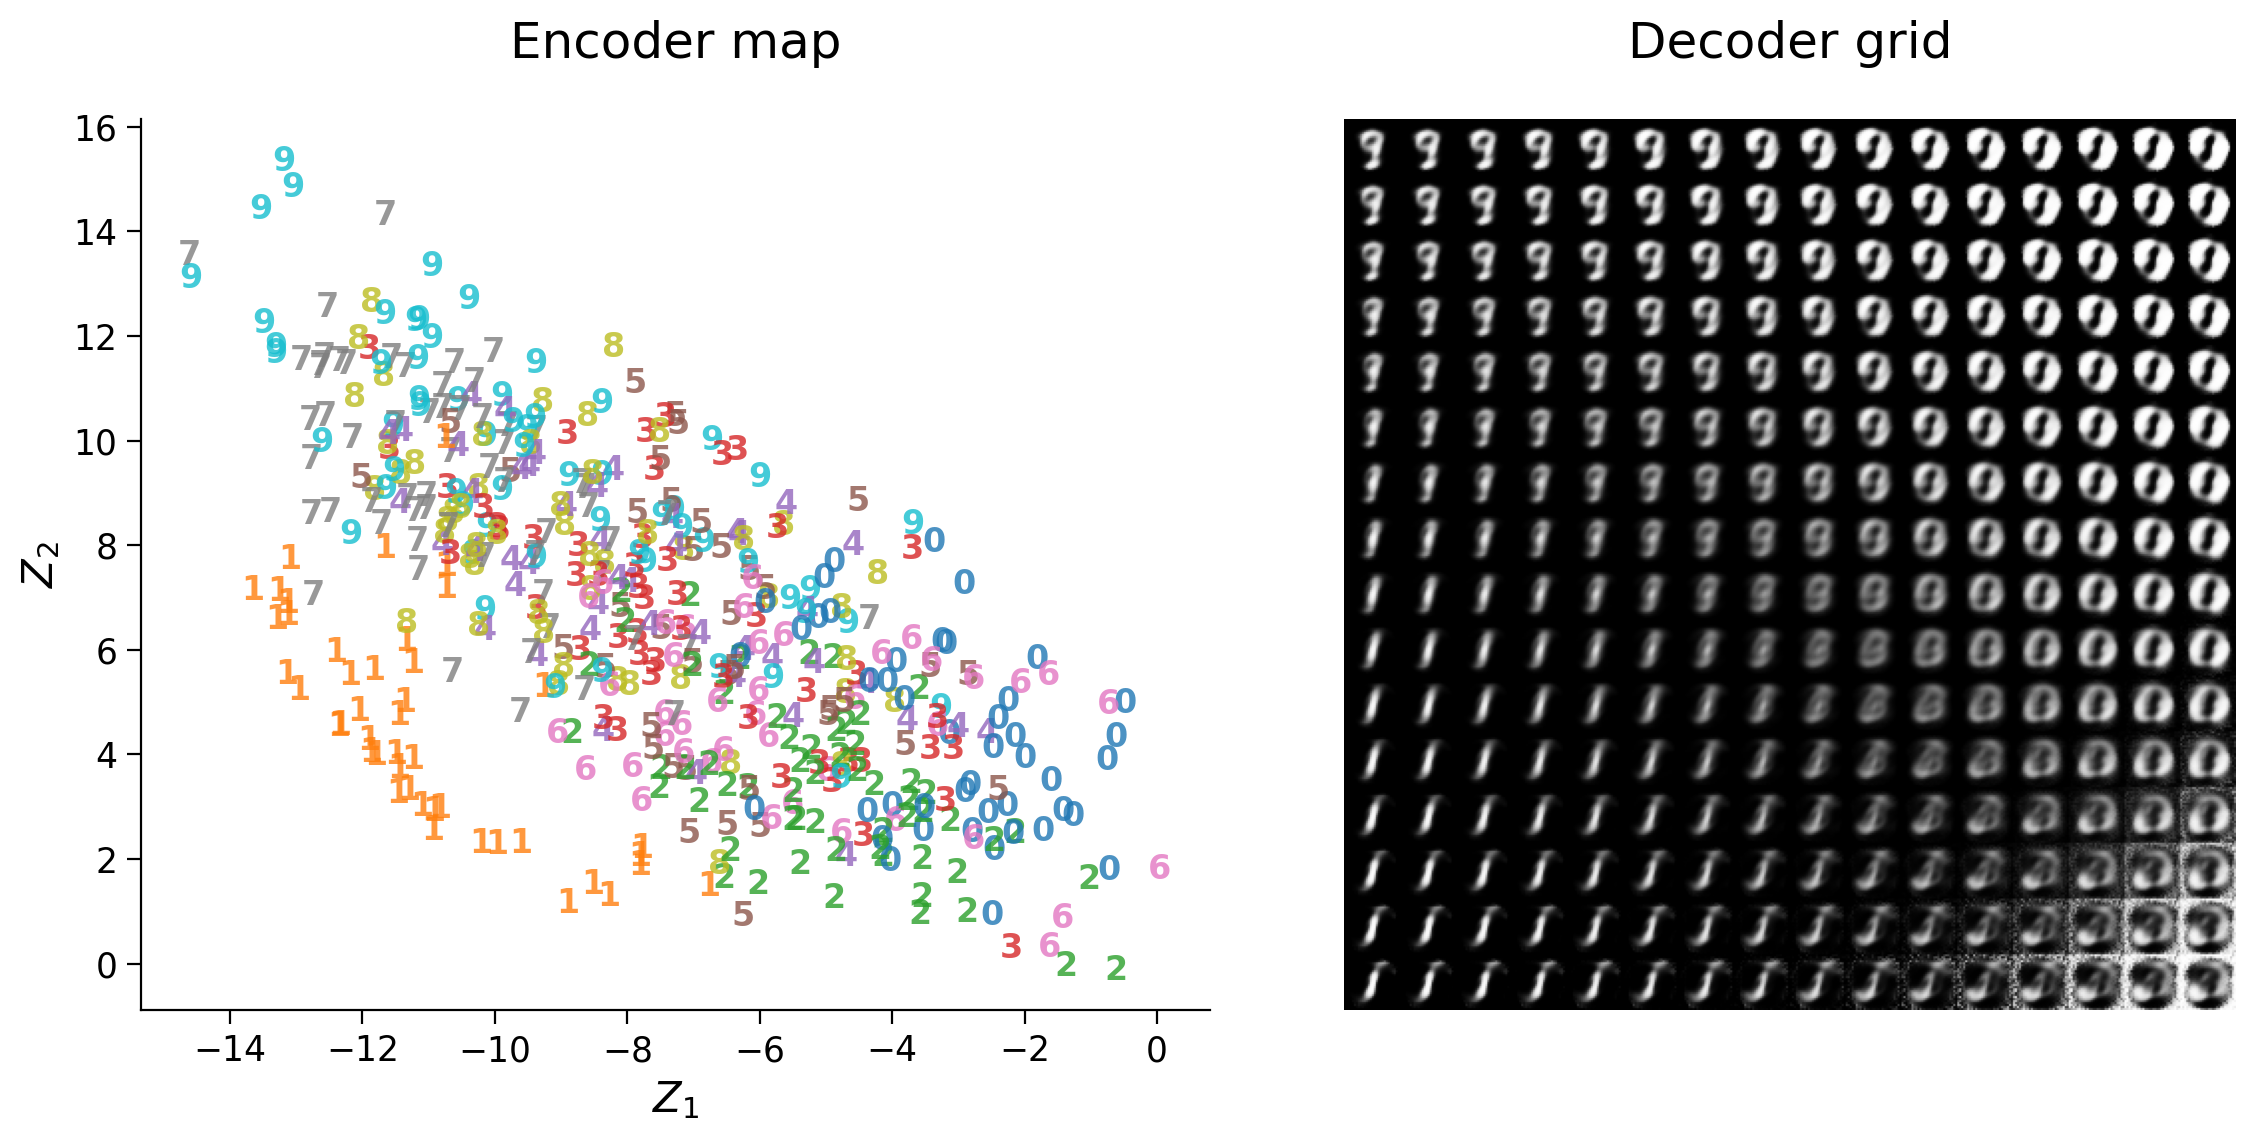

In [15]:
n_epochs = 10
batch_size = 64

# train the autoencoder
runSGD(model, input_train, input_test, criterion='bce',
       n_epochs=n_epochs, batch_size=batch_size)
with torch.no_grad():
  latent_test = encoder(input_test)

plot_latent_generative(latent_test, y_test, decoder,
                       image_shape=image_shape)

/tmp/ipykernel_79569/3600056542.py:381: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xlim, ylim = xy_lim(np.array(x))


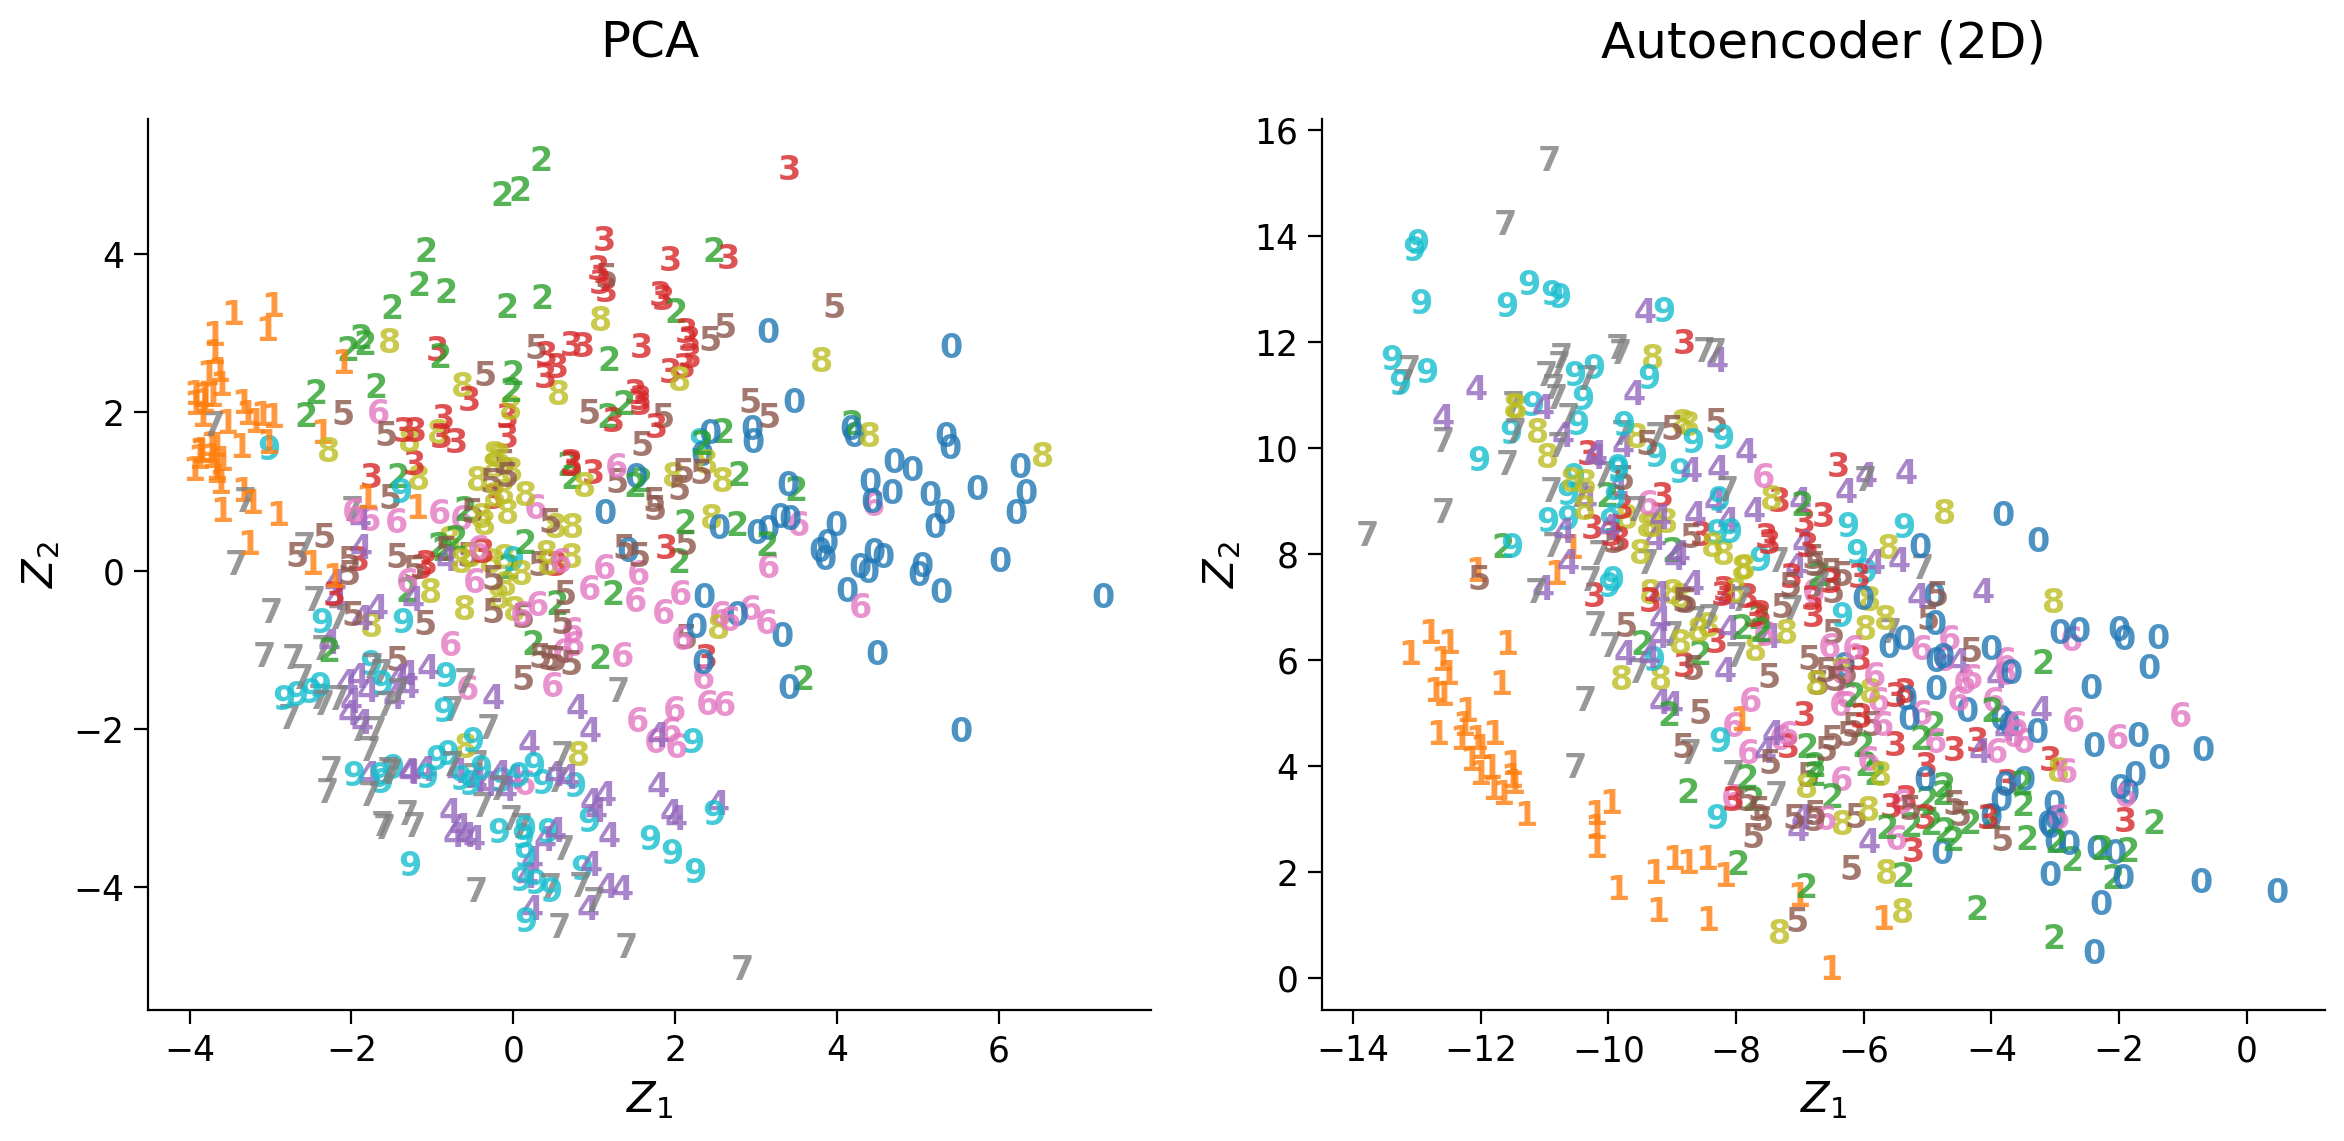

In [16]:
plot_latent_ab(pca_latent_test, latent_test, y_test,
               title_a='PCA', title_b='Autoencoder (2D)')

#### Deep Autoencoder

In [17]:
encoding_size = 2

## add layers to build deeper autoencoder


model = nn.Sequential(
    nn.Linear(input_size, int(input_size / 2)),
    nn.PReLU(),
    nn.Linear(int(input_size / 2), encoding_size * 32),
    nn.PReLU(),
    nn.Linear(encoding_size * 32, encoding_size),
    nn.PReLU(),
    nn.Linear(encoding_size, encoding_size * 32),
    nn.PReLU(),
    nn.Linear(encoding_size * 32, int(input_size / 2)),
    nn.PReLU(),
    nn.Linear(int(input_size / 2), input_size),
    nn.Sigmoid()
    )

model[:-2].apply(init_weights_kaiming_normal)

print(f'Autoencoder \n\n {model}\n')

# Adjust the value n_l to split your model correctly
n_l = len(model) // 2

# uncomment when you fill the code
encoder = model[:n_l]
decoder = model[n_l:]
print(f'Encoder \n\n {encoder}\n')
print(f'Decoder \n\n {decoder}')

Autoencoder 

 Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=392, out_features=64, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): PReLU(num_parameters=1)
  (6): Linear(in_features=2, out_features=64, bias=True)
  (7): PReLU(num_parameters=1)
  (8): Linear(in_features=64, out_features=392, bias=True)
  (9): PReLU(num_parameters=1)
  (10): Linear(in_features=392, out_features=784, bias=True)
  (11): Sigmoid()
)

Encoder 

 Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=392, out_features=64, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): PReLU(num_parameters=1)
)

Decoder 

 Sequential(
  (6): Linear(in_features=2, out_features=64, bias=True)
  (7): PReLU(num_parameters=1)
  (8): Linear(in_features=64, out_feat

Epoch 	 Loss train 	 Loss test
1 / 10	 0.2061		 0.2060
2 / 10	 0.1941		 0.1938
3 / 10	 0.1877		 0.1881
4 / 10	 0.1840		 0.1847
5 / 10	 0.1812		 0.1820
6 / 10	 0.1796		 0.1805
7 / 10	 0.1779		 0.1790
8 / 10	 0.1760		 0.1775
9 / 10	 0.1745		 0.1763
10 / 10	 0.1742		 0.1758


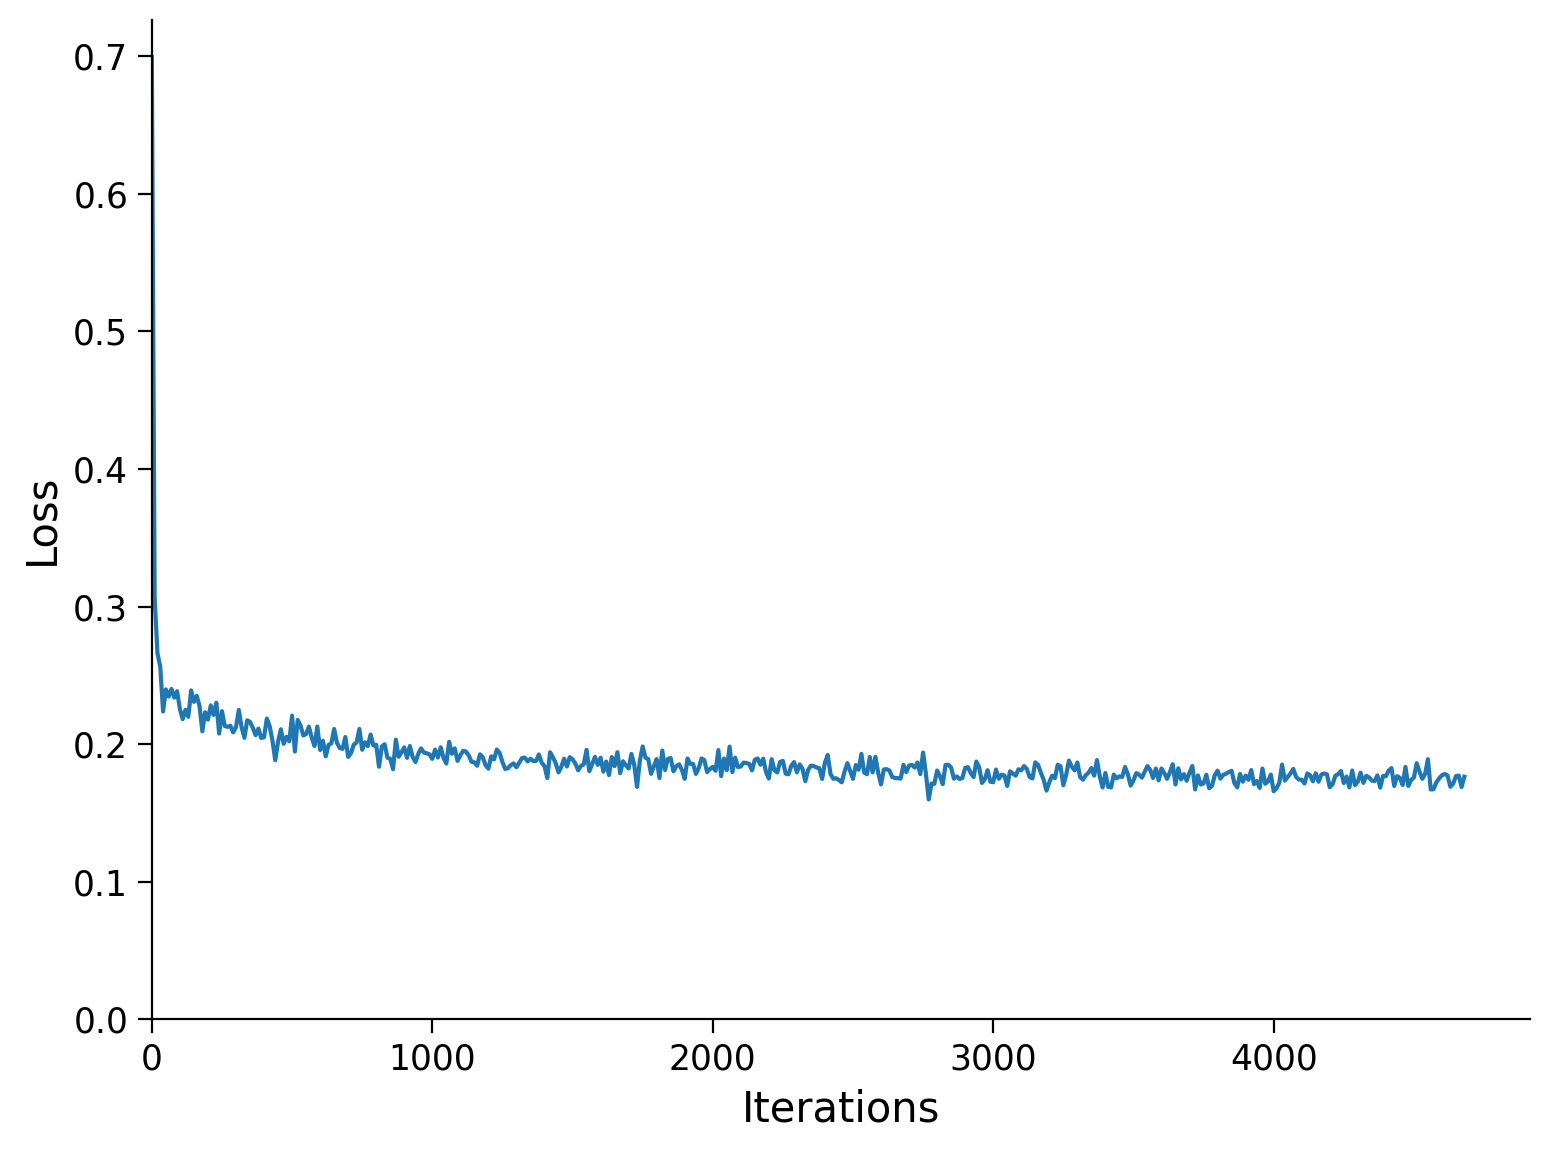

/tmp/ipykernel_79569/3600056542.py:242: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  items = np.array(items)
/tmp/ipykernel_79569/3600056542.py:381: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xlim, ylim = xy_lim(np.array(x))
/tmp/ipykernel_79569/3600056542.py:307: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide h

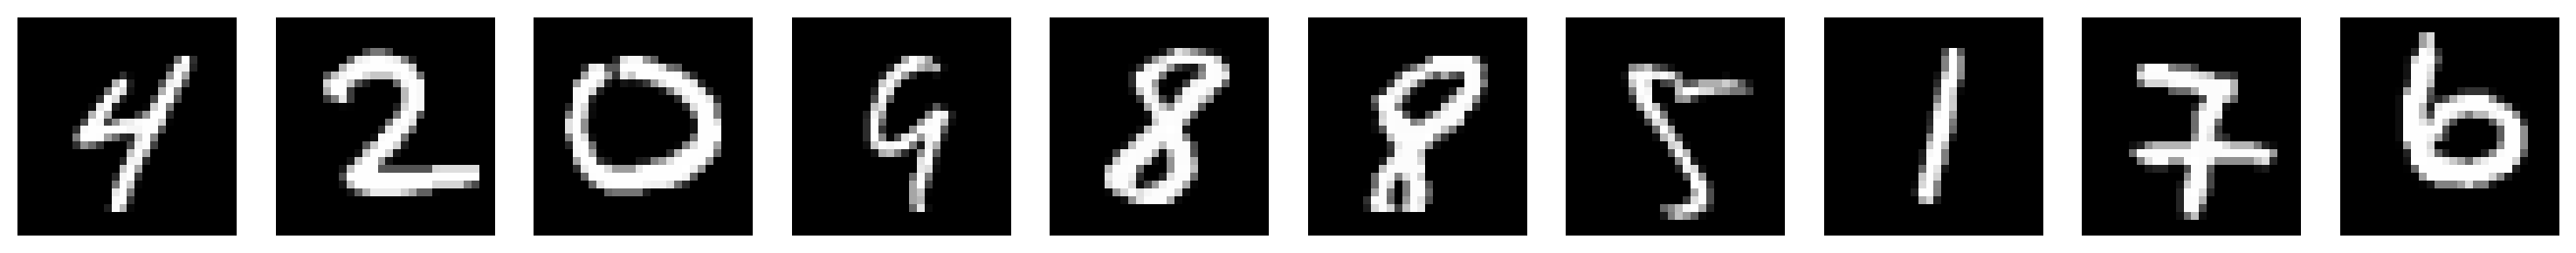

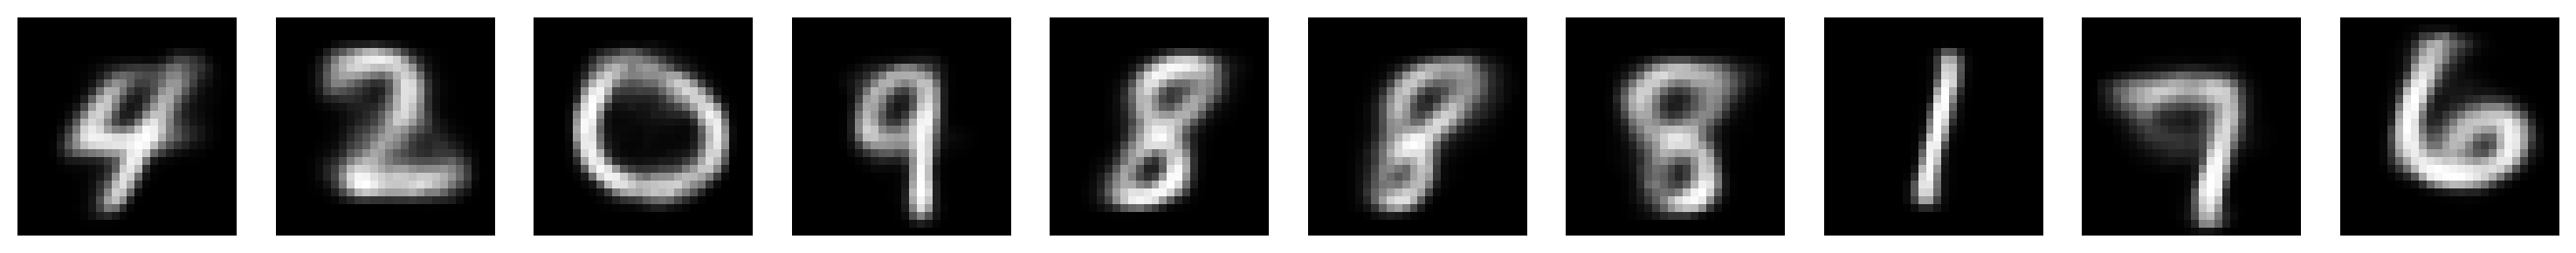

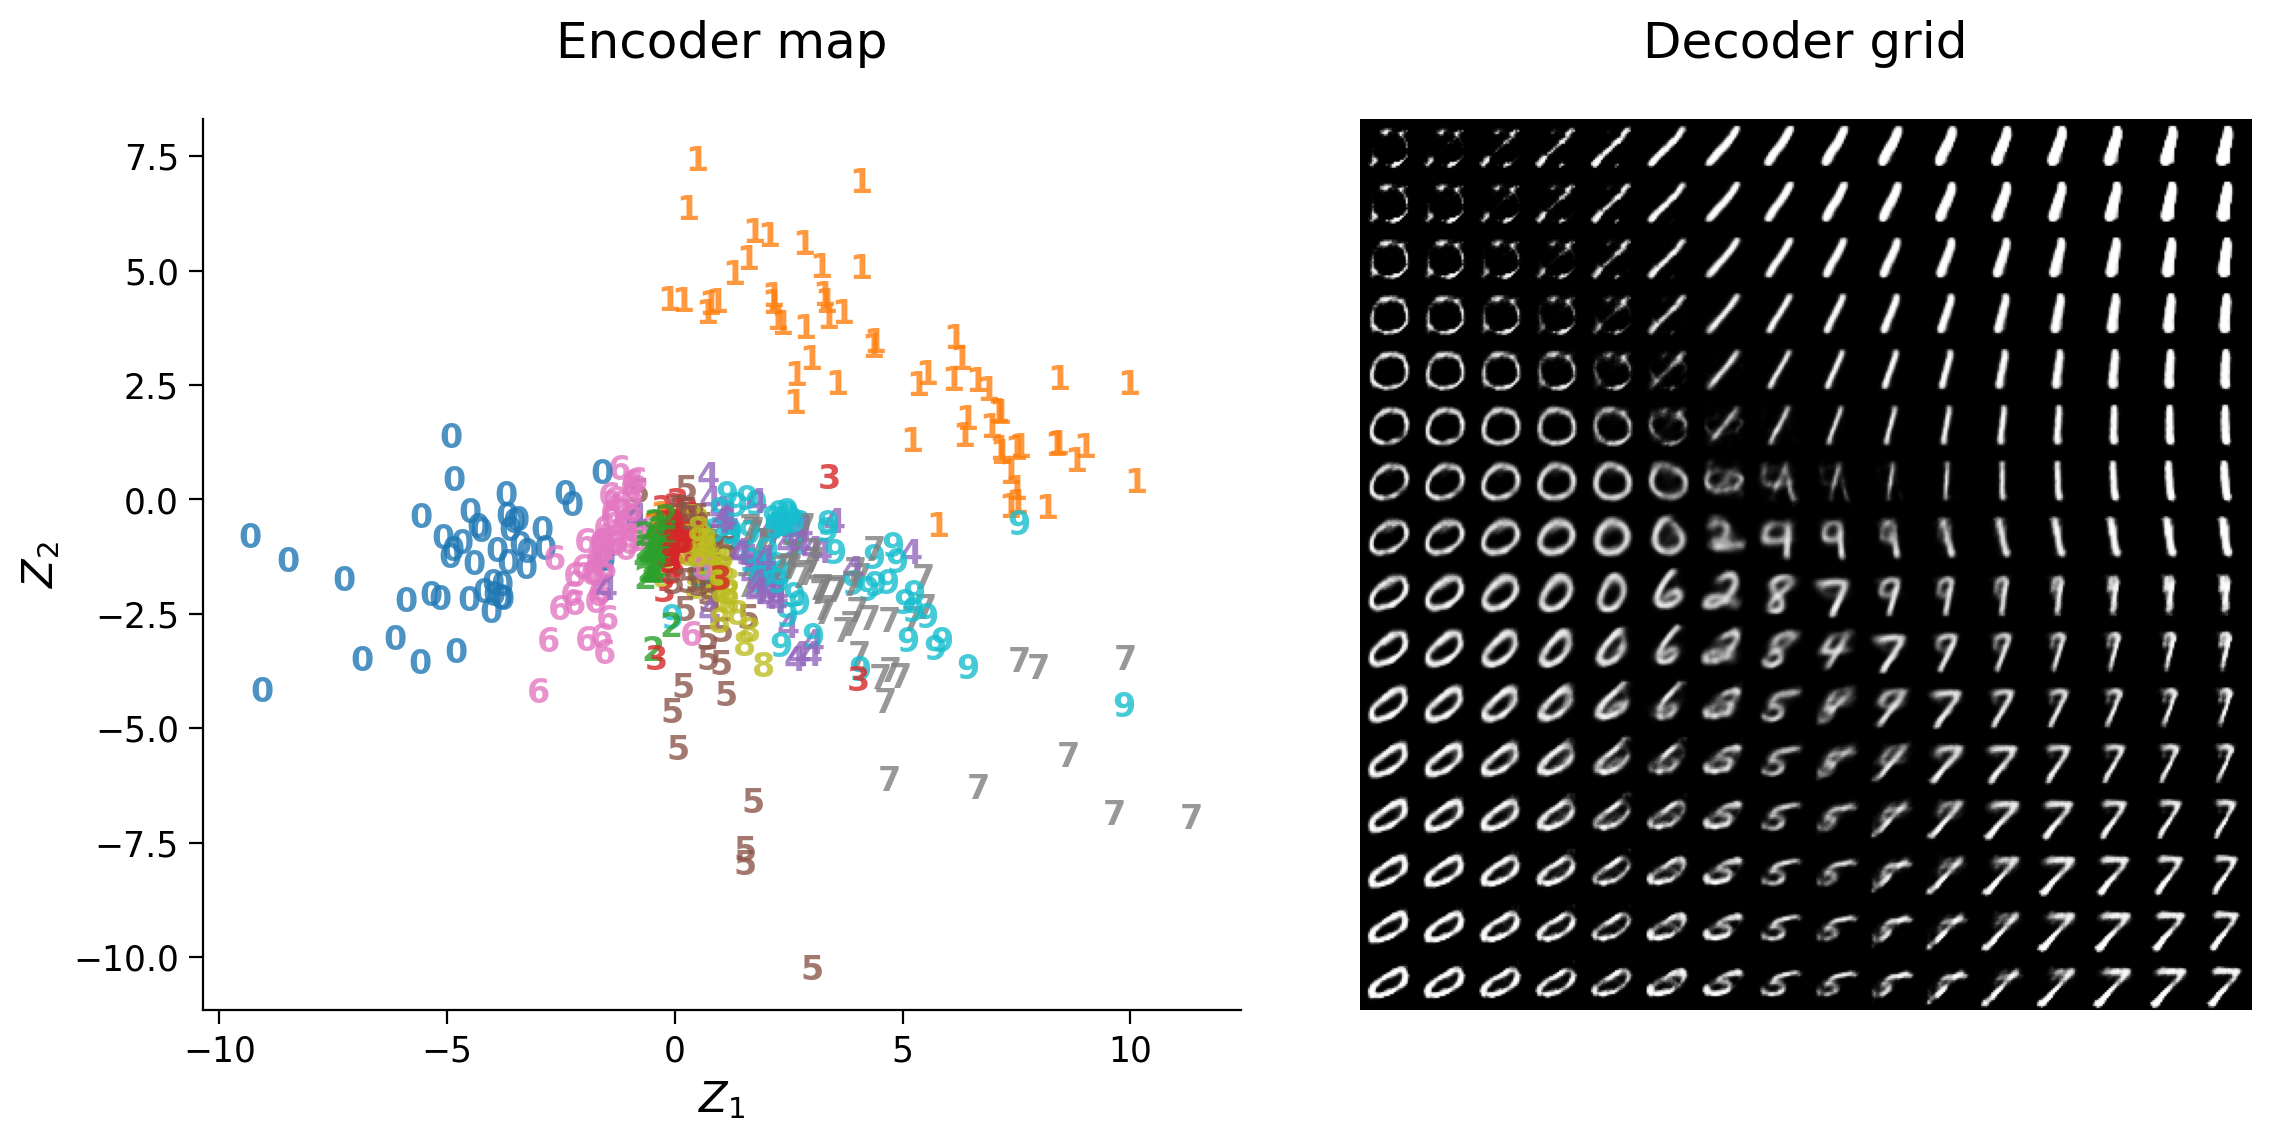

In [18]:
n_epochs = 10
batch_size = 128

runSGD(model, input_train, input_test, n_epochs=n_epochs,
       batch_size=batch_size)

with torch.no_grad():
  output_test = model(input_test)
  latent_test = encoder(input_test)

plot_row([input_test[test_selected_idx], output_test[test_selected_idx]],
         image_shape=image_shape)

plot_latent_generative(latent_test, y_test, decoder, image_shape=image_shape)

In [19]:
encoding_size = 3

model = nn.Sequential(
    nn.Linear(input_size, int(input_size / 2)),
    nn.PReLU(),
    nn.Linear(int(input_size / 2), encoding_size * 32),
    nn.PReLU(),
    nn.Linear(encoding_size * 32, encoding_size),
    nn.PReLU(),
    nn.Linear(encoding_size, encoding_size * 32),
    nn.PReLU(),
    nn.Linear(encoding_size * 32, int(input_size / 2)),
    nn.PReLU(),
    nn.Linear(int(input_size / 2), input_size),
    nn.Sigmoid()
    )

model[:-2].apply(init_weights_kaiming_normal)

encoder = model[:6]
decoder = model[6:]

print(f'Autoencoder \n\n {model}')

Autoencoder 

 Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=392, out_features=96, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=96, out_features=3, bias=True)
  (5): PReLU(num_parameters=1)
  (6): Linear(in_features=3, out_features=96, bias=True)
  (7): PReLU(num_parameters=1)
  (8): Linear(in_features=96, out_features=392, bias=True)
  (9): PReLU(num_parameters=1)
  (10): Linear(in_features=392, out_features=784, bias=True)
  (11): Sigmoid()
)


In [20]:
import plotly.graph_objects as go
from plotly.colors import qualitative

In [21]:
def plot_latent_3d(my_x, my_y, show_text=True, show_n=500):
  """
  Plot digit class or marker in 3D latent space coordinates.

  Args:
    my_x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space

    my_y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    show_text (boolean)
        whether to show text

    image_shape (tuple or list)
        original shape of image

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)

    title (string)
        plot title

  Returns:
    Nothing.
  """

  layout = {'margin': {'l': 0, 'r': 0, 'b': 0, 't': 0},
            'scene': {'xaxis': {'showspikes': False,
                                'title': 'z1'},
                      'yaxis': {'showspikes': False,
                                'title': 'z2'},
                      'zaxis': {'showspikes': False,
                                'title': 'z3'}}
            }

  selected_idx = np.random.choice(len(my_x), show_n, replace=False)

  colors = [qualitative.T10[idx] for idx in my_y[selected_idx]]

  x = my_x[selected_idx, 0]
  y = my_x[selected_idx, 1]
  z = my_x[selected_idx, 2]

  text = my_y[selected_idx]

  if show_text:

    trace = go.Scatter3d(x=x, y=y, z=z, text=text,
                         mode='text',
                         textfont={'color': colors, 'size': 12}
                         )

    layout['hovermode'] = False

  else:

    trace = go.Scatter3d(x=x, y=y, z=z, text=text,
                         hoverinfo='text', mode='markers',
                         marker={'size': 5, 'color': colors, 'opacity': 0.8}
                         )

  fig = go.Figure(data=trace, layout=layout)

  fig.show()

Epoch 	 Loss train 	 Loss test
1 / 10	 0.1855		 0.1854
2 / 10	 0.1744		 0.1750
3 / 10	 0.1682		 0.1691
4 / 10	 0.1642		 0.1654
5 / 10	 0.1614		 0.1631
6 / 10	 0.1600		 0.1619
7 / 10	 0.1578		 0.1602
8 / 10	 0.1560		 0.1588
9 / 10	 0.1553		 0.1583
10 / 10	 0.1542		 0.1574


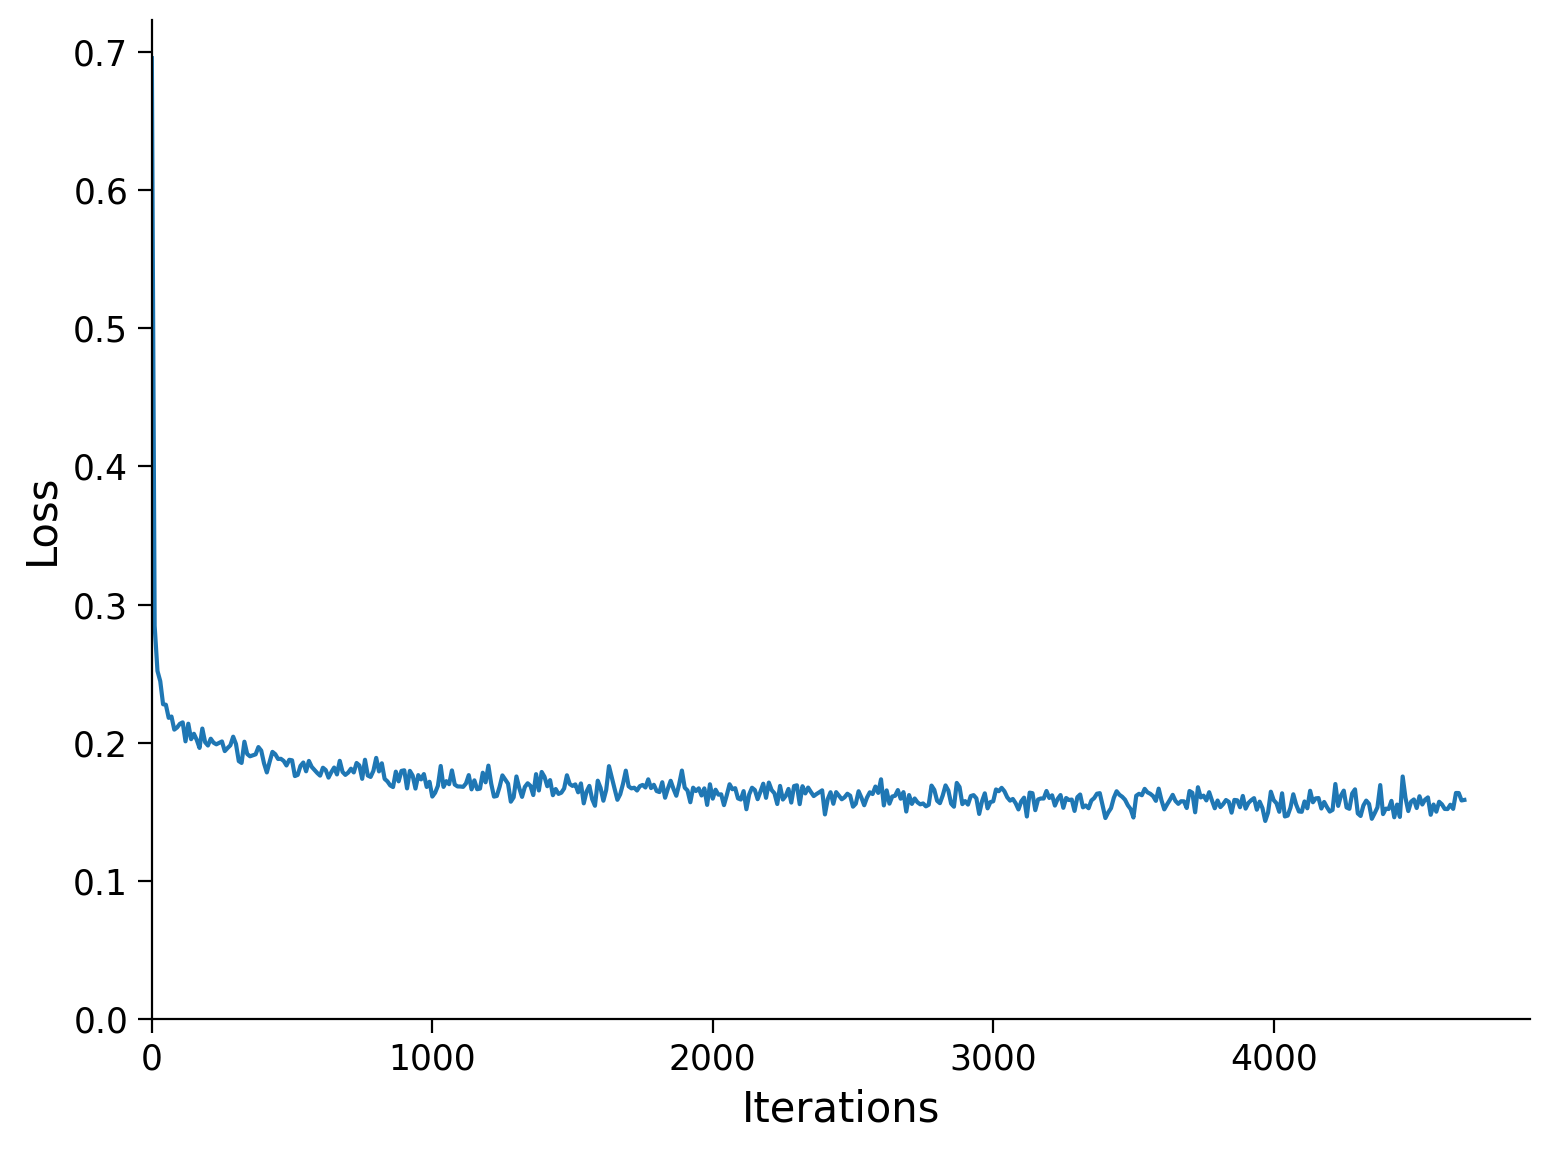

In [22]:
n_epochs = 10
batch_size = 128

runSGD(model, input_train, input_test, n_epochs=n_epochs,
       batch_size=batch_size)

with torch.no_grad():
  latent_test = encoder(input_test)

plot_latent_3d(latent_test, y_test)

In [34]:
def to_s2(u):
  """
  Projects 3D coordinates to spherical coordinates (theta, phi) surface of
  unit sphere S2.
  theta: [0, pi]
  phi: [-pi, pi]

  Args:
    u (list, numpy array or torch.Tensor of floats)
        3D coordinates

  Returns:
    Spherical coordinates (theta, phi) on surface of unit sphere S2.
  """

  x, y, z = (u[:, 0], u[:, 1], u[:, 2])
  r = np.sqrt(x**2 + y**2 + z**2)
  theta = np.arccos(z / r)
  phi = np.arctan2(x, y)

  return np.array([theta, phi]).T


def to_u3(s):
  """
  Converts from 2D coordinates on surface of unit sphere S2 to 3D coordinates
  (on surface of S2), i.e. (theta, phi) ---> (1, theta, phi).

  Args:
    s (list, numpy array or torch.Tensor of floats)
        2D coordinates on unit sphere S_2

  Returns:
    3D coordinates on surface of unit sphere S_2
  """

  theta, phi = (s[:, 0], s[:, 1])
  x = np.sin(theta) * np.sin(phi)
  y = np.sin(theta) * np.cos(phi)
  z = np.cos(theta)

  return np.array([x, y, z]).T

def plot_generative(x, decoder_fn, image_shape, n_row=16, s2=False):
  """
  Plots images reconstructed by decoder_fn from a 2D grid in
  latent space that is determined by minimum and maximum values in x.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D or 3D coordinates in latent space

    decoder_fn (integer)
        function returning vectorized images from 2D latent space coordinates

    image_shape (tuple or list)
        original shape of image

    n_row (integer)
        number of rows in grid

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)

  Returns:
    Nothing.
  """

  if s2:
    x = to_s2(np.array(x))

  xlim, ylim = xy_lim(np.array(x))

  dx = (xlim[1] - xlim[0]) / n_row
  grid = [np.linspace(ylim[0] + dx / 2, ylim[1] - dx / 2, n_row),
          np.linspace(xlim[0] + dx / 2, xlim[1] - dx / 2, n_row)]

  canvas = np.zeros((image_shape[0] * n_row, image_shape[1] * n_row))

  cmap = plt.get_cmap('gray')

  for j, latent_y in enumerate(grid[0][::-1]):
    for i, latent_x in enumerate(grid[1]):

      latent = np.array([[latent_x, latent_y]], dtype=np.float32)

      if s2:
        latent = to_u3(latent)

      with torch.no_grad():
        x_decoded = decoder_fn(torch.from_numpy(latent))

      x_decoded = x_decoded.reshape(image_shape)

      canvas[j * image_shape[0]: (j + 1) * image_shape[0],
             i * image_shape[1]: (i + 1) * image_shape[1]] = x_decoded

  plt.imshow(canvas, cmap=cmap, vmin=canvas.min(), vmax=canvas.max())
  plt.axis('off')


def plot_latent(x, y, show_n=500, s2=False, fontdict=None, xy_labels=None):
  """
  Plots digit class of each sample in 2D latent space coordinates.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    n_row (integer)
        number of samples

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)

    fontdict (dictionary)
        style option for plt.text

    xy_labels (list)
        optional list with [xlabel, ylabel]

  Returns:
    Nothing.
  """

  if fontdict is None:
    fontdict = {'weight': 'bold', 'size': 12}

  if s2:
    x = to_s2(np.array(x))

  cmap = plt.get_cmap('tab10')

  if len(x) > show_n:
    selected = np.random.choice(len(x), show_n, replace=False)
    x = x[selected]
    y = y[selected]

  for my_x, my_y in zip(x, y):
    plt.text(my_x[0], my_x[1], str(int(my_y)),
             color=cmap(int(my_y) / 10.),
             fontdict=fontdict,
             horizontalalignment='center',
             verticalalignment='center',
             alpha=0.8)

  xlim, ylim = xy_lim(np.array(x))
  plt.xlim(xlim)
  plt.ylim(ylim)

  if s2:
    if xy_labels is None:
      xy_labels = [r'$\varphi$', r'$\theta$']

    plt.xticks(np.arange(0, np.pi + np.pi / 6, np.pi / 6),
               ['0', '$\\pi/6$', '$\\pi/3$', '$\\pi/2$',
                '$2\\pi/3$', '$5\\pi/6$', '$\\pi$'])
    plt.yticks(np.arange(-np.pi, np.pi + np.pi / 3, np.pi / 3),
               ['$-\\pi$', '$-2\\pi/3$', '$-\\pi/3$', '0',
                '$\\pi/3$', '$2\\pi/3$', '$\\pi$'])

  if xy_labels is None:
    xy_labels = ['$Z_1$', '$Z_2$']

  plt.xlabel(xy_labels[0])
  plt.ylabel(xy_labels[1])


def plot_latent_generative(x, y, decoder_fn, image_shape, s2=False,
                           title=None, xy_labels=None):
  """
  Two horizontal subplots generated with encoder map and decoder grid.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    decoder_fn (integer)
        function returning vectorized images from 2D latent space coordinates

    image_shape (tuple or list)
        original shape of image

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)

    title (string)
        plot title

    xy_labels (list)
        optional list with [xlabel, ylabel]

  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=(12, 6))

  if title is not None:
    fig.suptitle(title, y=1.05)

  ax = fig.add_subplot(121)
  ax.set_title('Encoder map', y=1.05)
  plot_latent(x, y, s2=s2, xy_labels=xy_labels)

  ax = fig.add_subplot(122)
  ax.set_title('Decoder grid', y=1.05)
  plot_generative(x, decoder_fn, image_shape, s2=s2)

  plt.tight_layout()
  plt.show()


/tmp/ipykernel_79569/3600056542.py:242: DeprecationWarning:

__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword

/tmp/ipykernel_79569/4155083407.py:133: DeprecationWarning:

__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword

/tmp/ipykernel_79569/4155083407.py:70: DeprecationWarning:

__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#a

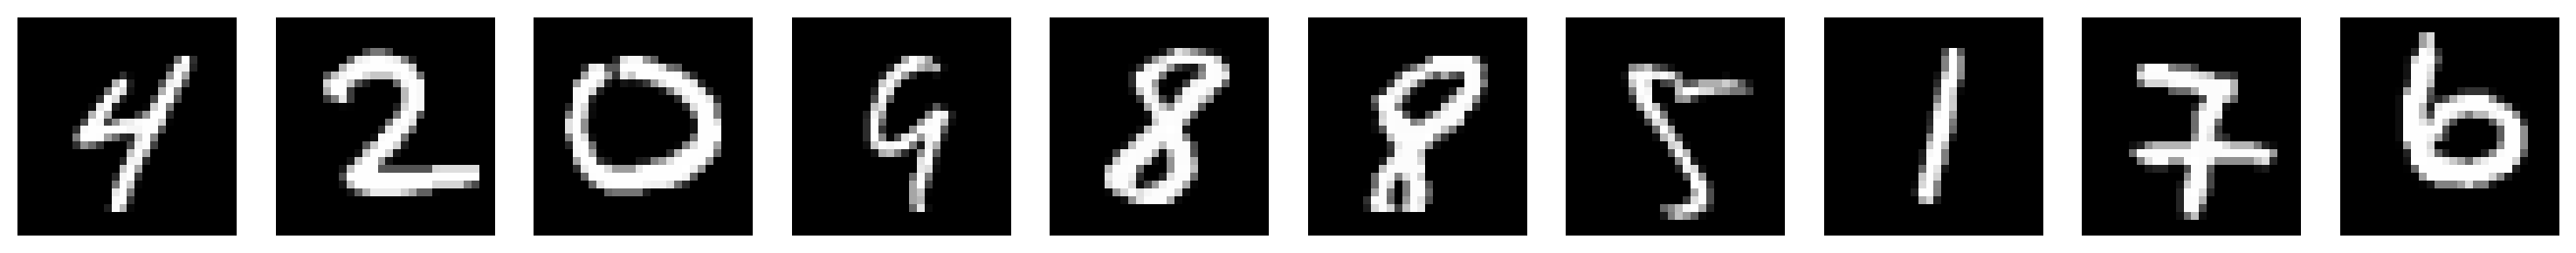

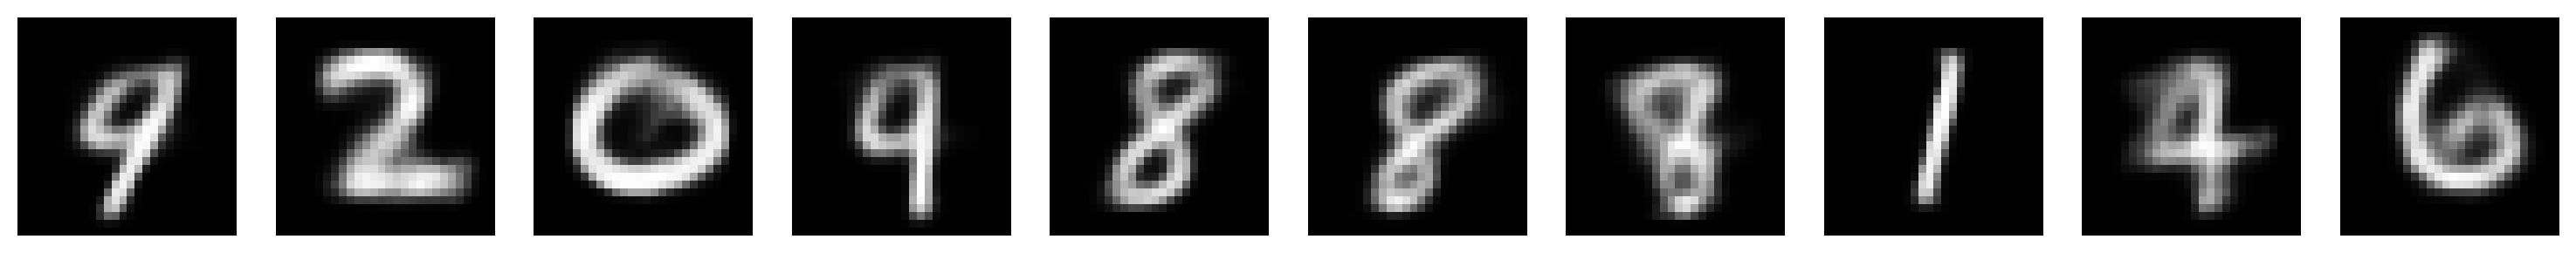

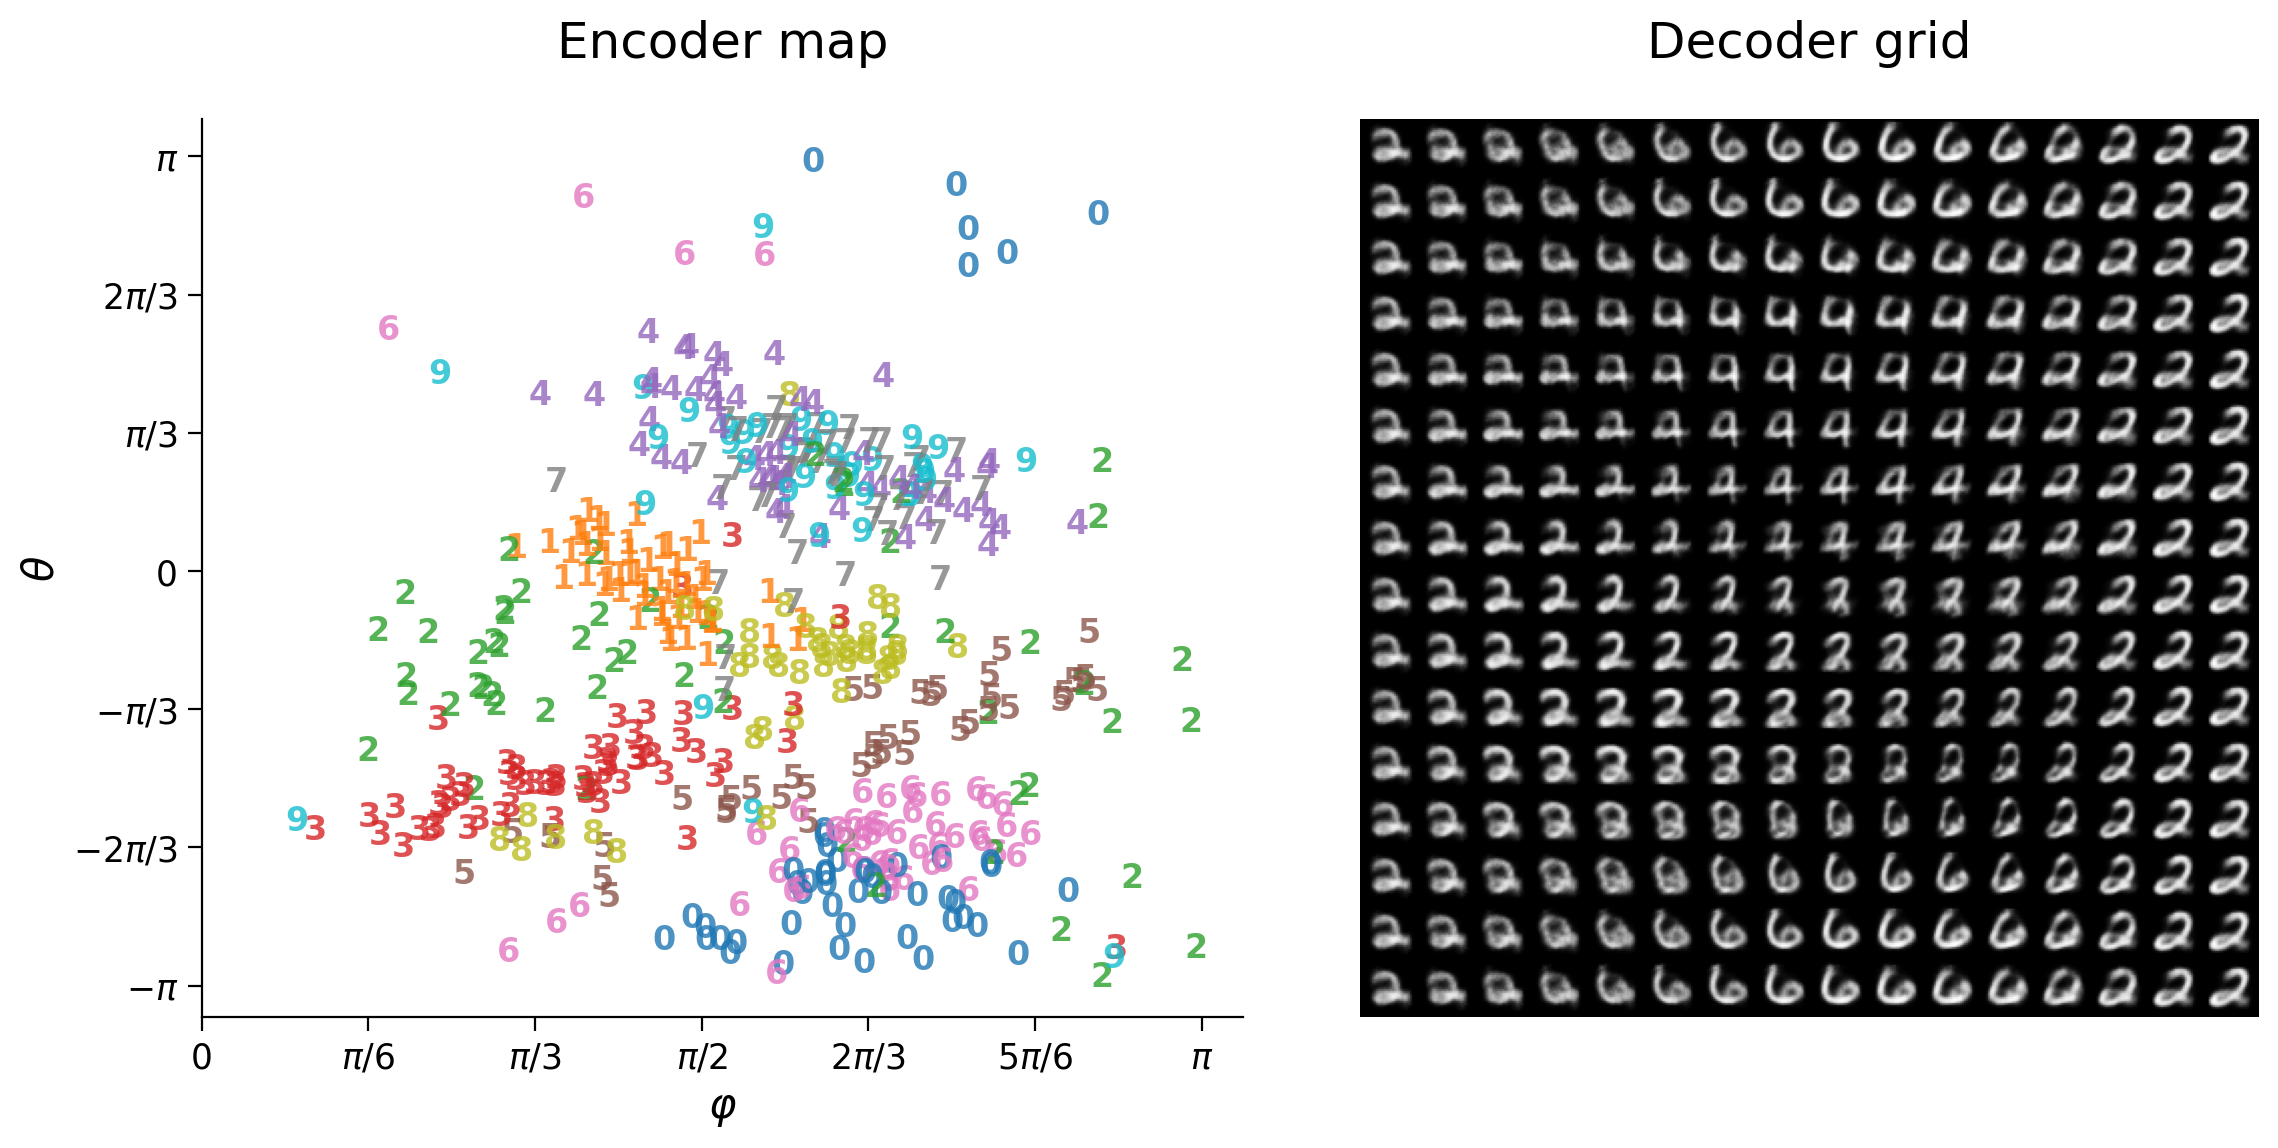

In [35]:
with torch.no_grad():
  output_test = model(input_test)

plot_row([input_test[test_selected_idx], output_test[test_selected_idx]],
         image_shape=image_shape)

plot_latent_generative(latent_test, y_test, decoder,
                       image_shape=image_shape, s2=True)